## Setup

In [36]:
# Libraries
import pandas as pd
import numpy as np
import gpflow 
import pickle
from helper_functions import *

# Options
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

In [37]:
# Libraries
import pandas as pd
import numpy as np
import gpflow 
import pickle
from helper_functions import *

# Options
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

# Data
# Read in metabolomics data
mbx = pd.read_csv('../examples/iHMP/data/iHMP_labeled_metabolomics.csv')
# Subset metabolites to labeled sets

# Get metabolite list
mbx_list = mbx.Metabolite
# Reshape metabolites for merge
mbx = mbx.iloc[:,7:].transpose().rename(columns = mbx_list)
# Only keep metabolites that have at least 20% non-missing values
mbx_list = mbx_list[(mbx.notna().mean() >= 0.2).values]
mbx = mbx[mbx_list]

# Read in metadata for timing of samples
meta = pd.read_csv('../examples/iHMP/data/iHMP_metadata.csv')
# Subset metadata to appropriate samples and columns of interest
meta = meta[meta['External ID'].isin(mbx.index)][['External ID', 'Participant ID', 
                                                  'date_of_receipt', 'diagnosis',
                                                  'hbi', 'sccai', 'race', 'sex',
                                                  #'Age at diagnosis', 'consent_age',
                                                  #'site_name'
                                                 ]]
meta.set_index('External ID', inplace=True)

# Combine severity scores
meta['severity'] = np.where(meta['diagnosis'] == 'CD', meta.hbi, meta.sccai)
meta['severity'] = np.where(meta['diagnosis'] == 'nonIBD', 0, meta['severity'])

# Make sure that intensities are numeric and log transform them
log_mbx = np.log(mbx.astype('double'))

# Calculate the means and standard deviations of each column
log_means = log_mbx.mean()
log_stds = log_mbx.std()

# Transform dataset
log_mbx = (log_mbx - log_means)/log_stds

# Merge metabolomics info to metadata
df = (meta.merge(mbx, #log_mbx, 
                 left_index = True, 
           right_index = True).
      drop_duplicates().
      rename(columns = {'Participant ID': 'id',
                        'date_of_receipt': 'date'#,
#                         0: 'intensity'
                       }))

# Fix the date column
df.date = pd.to_datetime(df.date)

# Now scale the dates compared to the earliest date
min_date = df.date.min()
df['days_from_start'] = (df.date - min_date).dt.days

# Find the max severity day for each ID
max_date = df[['id', 'severity', 'date']].\
    dropna(subset=['severity']).\
    sort_values(['severity', 'date'], ascending=[True, False]).\
    groupby('id').\
    tail(1).\
    drop(columns=['severity']).\
    rename(columns={'date': 'max_severity_date'})

# Merge to get the median date for controls
max_date = max_date.merge(
    right=df.query("diagnosis == 'nonIBD'")[['id', 'date']].\
        groupby('id', as_index=False).\
        apply(lambda x: x.iloc[int(np.floor((len(x)+1)//2))]).\
        rename(columns={'date': 'med_severity_date'}),
    on='id',
    how='left'
)
# Use median date if available, otherwise use computed value
max_date['max_severity_date'] = max_date.med_severity_date.combine_first(max_date.max_severity_date)
# Drop unnecessary column
max_date.drop(columns=['med_severity_date'], inplace=True)

# Merge this back to df
df = pd.merge(df, max_date, on='id')
df['days_from_max_severity'] = (df.date - df.max_severity_date).dt.days
df = df.drop(columns=['max_severity_date'])

# Drop columns that aren't needed (drop id for the moment)
df = df.drop(columns=['date'])#, 'id'])

# Drop duplicate metabolites
df = df.loc[:,~df.columns.duplicated()]

# Only keep CD observations because they have hbi
# df = df.query("diagnosis == 'CD'").drop(columns = ['diagnosis'])

# Only keep non-missing severity for the moment
# df = df[df.hbi.notna()]

# Fill in severity scores for individuals, last carry forward 
df['severity'] = df[['id', 'severity']].\
    groupby('id').\
    fillna(method='ffill')
df = df[df.severity.notna()]
df = df.drop(columns=['hbi', 'sccai'])

# Drop UC individuals for now
df = df.query("diagnosis != 'UC'")
df = df.query("diagnosis == 'CD'")
df = df.drop(columns=['diagnosis'])

# Store individual information look up vectors
# Get numerics for each categorical value as well as the lookup index
df['id'], id_map = pd.factorize(df['id'])
# df['diagnosis'], diagnosis_map = pd.factorize(df['diagnosis'])
df['race'], race_map = pd.factorize(df['race'])
df['sex'], sex_map = pd.factorize(df['sex'])
# n_id = df.id.nunique()
# id_list = df.id.unique()
# id_vals = df.id.values
# id_idx = np.array([np.where(id_list == x)[0][0] for x in id_vals])
# df['id'] = id_idx

# Only keep metabolites 
df_original = df.copy()

# Standardize severity and days for convergence properties
df.days_from_start = (df.days_from_start - df.days_from_start.mean())/df.days_from_start.std()
df.days_from_max_severity = (df.days_from_max_severity - df.days_from_max_severity.mean())/df.days_from_max_severity.std()
df.severity = (df.severity - df.severity.mean())/df.severity.std()

# Normalize columns
# df.days_from_start = (df.days_from_start.max() - df.days_from_start)/(df.days_from_start.max()-df.days_from_start.min())
# df.hbi = (df.hbi.max() - df.hbi)/(df.hbi.max() - df.hbi.min())
# df.id = (df.id.max() - df.id)/(df.id.max() - df.id.min())
# df.id = (df.id - df.id.mean())/df.id.std()
print(df.shape)
df.head()

# Specify the covariate features of interest
feat_names = col_names = ['id', # 'diagnosis', 
                          'race', 'sex', 
                          'severity', 
                          'days_from_start', 
                          'days_from_max_severity']
df.shape

# Get percent missing for each column and then only flag metabolites with at least 1% observations missing
missing_mbx_list = list(df.drop(columns=feat_names).columns[
    df.drop(columns=feat_names).isna().mean(axis=0) > 0.01
])

# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               # gpflow.kernels.ArcCosine(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

# Number of metabolites
n_met = len(missing_mbx_list)

(257, 550)


/var/folders/2w/r7x976td4f97twg4r5ff50500000gn/T/ipykernel_75961/4267501208.py:27: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('../examples/iHMP/data/iHMP_metadata.csv')


In [38]:
# # Specify the covariate features of interest
# feat_names = col_names = ['id', #'diagnosis', 
#                           'race', 'sex', #'age',
#                           'severity', 
#                           'days_from_start', 
#                           'days_from_max_severity']
# df.shape

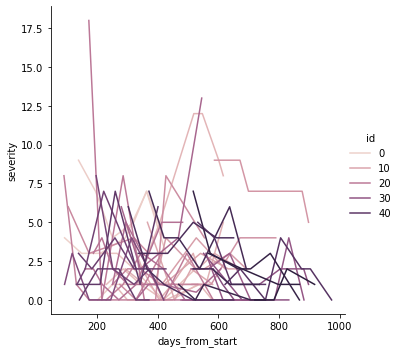

In [39]:
sns.relplot(
    x="days_from_start",
    y="severity",
    hue="id",
    #col="diagnosis",
    kind="line",
    data=df_original
)

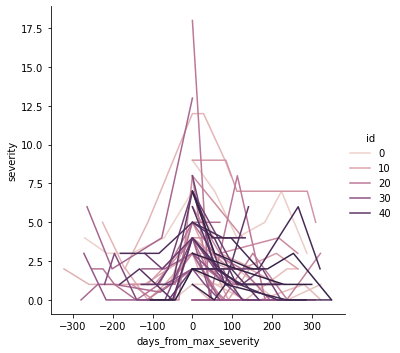

In [40]:
sns.relplot(
    x="days_from_max_severity",
    y="severity",
    hue="id",
    #col="diagnosis",
    kind="line",
    data=df_original
)

## iHMP Stage One Model Search

In [41]:
feat_names

['id', 'race', 'sex', 'severity', 'days_from_start', 'days_from_max_severity']

In [42]:
stage1 = GPKernelSearch(
    X=df[feat_names],
    Y=df[missing_mbx_list].notna().astype(int),
    unit_col='id',
    categorical_vars=['id', 'race', 'sex'],
    outcome_likelihood='bernoulli'
)

In [43]:
stage1.run_search(
    kernels=kernel_list,
    random_seed=9102,
    num_jobs=8
)

import pickle 
# Save output
f = open("ihmp_binomial_models_local.pkl","wb")
pickle.dump(stage1, f)
f.close()

Kernel search: 100%|██████████████████████████████| 219/219 [5:09:43<00:00, 84.86s/it]


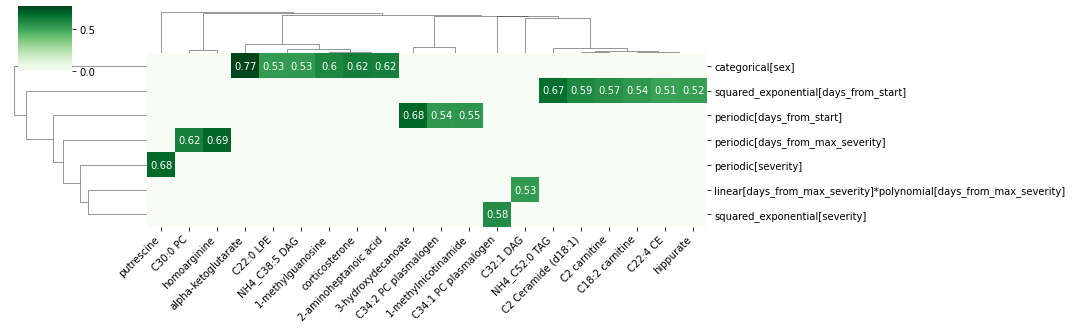

In [45]:
stage1.plot_heatmap(var_cutoff=0.5)

In [86]:
# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

bin_test_full = full_kernel_search(
    X=df[feat_names],
    Y=df[['C22:6 CE']].notna().astype(int),
    kern_list=kernel_list,
    cat_vars=[0, 1, 2, 3],
    max_depth=5,
    early_stopping=True,
    prune=True,
    keep_all=False,
    lik='bernoulli',
    keep_only_best=False,
    random_seed=9102,
    verbose=True,
    metric_diff=0
)

Working on depth 1 now
-----------

Working on depth 2 now
No better kernel found in layer, exiting search!
constant


In [87]:
[(k, v['bic']) for k, v in bin_test_full['models'].items()]

[('categorical[0]', -77477.56),
 ('constant', -77480.5),
 ('categorical[1]', -77477.56),
 ('categorical[2]', -77477.56),
 ('categorical[3]', -77477.56),
 ('squared_exponential[4]', -77471.59),
 ('matern12[4]', -77471.59),
 ('linear[4]', -77477.57),
 ('polynomial[4]', -77471.59),
 ('periodic[4]', -77465.62),
 ('squared_exponential[5]', -77471.59),
 ('matern12[5]', -76181.54),
 ('linear[5]', -77477.56),
 ('polynomial[5]', -77471.59),
 ('periodic[5]', -77465.62),
 ('squared_exponential[6]', -77471.59),
 ('matern12[6]', -77471.59),
 ('linear[6]', -77477.57),
 ('polynomial[6]', -77471.59),
 ('periodic[6]', -77465.62)]

In [77]:
# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

bin_test = split_kernel_search(
    X=df[feat_names],
    Y=df[['C22:6 CE']].notna().astype(int),
    kern_list=kernel_list,
    cat_vars=[0, 1, 2, 3],
    unit_idx=0,
    max_depth=5,
    early_stopping=True,
    prune=True,
    keep_all=False,
    lik='bernoulli',
    keep_only_best=False,
    random_seed=9102,
    verbose=True,
    metric_diff=1
)

Working on depth 1 now
-----------

Working on depth 2 now
-----------

Working on depth 3 now
No better kernel found in layer, exiting search!
Pruning now
matern12[6]+polynomial[6]


/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'matern12[days_from_max_severity] (19.0%)'}, xlabel='days_from_max_severity'>,
        <AxesSubplot:title={'center':'residuals (81.0%)'}, xlabel='days_from_max_severity'>],
       dtype=object))

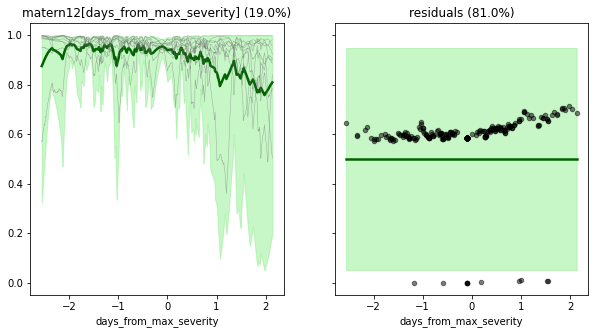

In [83]:
pred_kernel_parts(
    m=bin_test['models']['matern12[6]']['model'],
    k_names='matern12[6]',
    time_idx=6,
    unit_idx=0,
    col_names=feat_names,
    lik='bernoulli')

In [78]:
bin_test['models'][bin_test['best_model']]['model']

<gpflow.models.vgp.VGP object at 0x2da970a30>
╒════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════════════╕
│ name                               │ class     │ transform      │ prior   │ trainable   │ shape         │ dtype   │ value                    │
╞════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════════════╡
│ VGP.kernel.kernels[0].variance     │ Parameter │ Softplus       │ Gamma   │ True        │ ()            │ float64 │ 2.231327021644038e-08    │
├────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────┤
│ VGP.kernel.kernels[0].lengthscales │ Parameter │ Softplus       │ Gamma   │ True        │ ()            │ float64 │ 0.0006417454037765167    │
├────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────┤
│ VGP.kernel.kernels[1].variance     │ Parameter │ Softplus       │ Gamma   │ True        │ ()            │ float64 │ 2.474798260700839e-22    │
├────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────┤
│ VGP.kernel.kernels[1].offset       │ Parameter │ Softplus       │ Gamma   │ True        │ ()            │ float64 │ 1.4783979182755906       │
├────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────┤
│ VGP.q_mu                           │ Parameter │ Identity       │ Gamma   │ True        │ (266, 1)      │ float64 │ [[0.9682476...           │
├────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────┤
│ VGP.q_sqrt                         │ Parameter │ FillTriangular │ Gamma   │ True        │ (1, 266, 266) │ float64 │ [[[0.07619847, 0., 0.... │
╘════════════════════════════════════╧═══════════╧════════════════╧═════════╧═════════════╧═══════════════╧═════════╧══════════════════════════╛

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'matern12[days_from_max_severity] (0.0%)'}, xlabel='days_from_max_severity'>,
        <AxesSubplot:title={'center':'polynomial[days_from_max_severity] (0.0%)'}, xlabel='days_from_max_severity'>,
        <AxesSubplot:title={'center':'residuals (100.0%)'}, xlabel='days_from_max_severity'>],
       dtype=object))

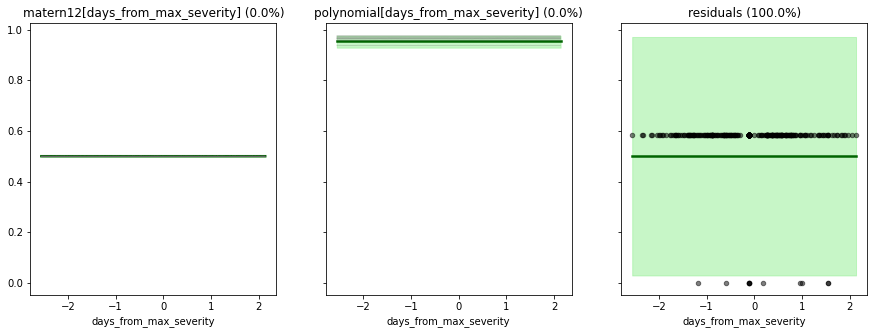

In [79]:
pred_kernel_parts(
    m=bin_test['models'][bin_test['best_model']]['model'],
    k_names=bin_test['best_model'],
    time_idx=6,
    unit_idx=0,
    col_names=feat_names,
    lik='bernoulli')

In [10]:
# Get percent missing for each column and then only flag metabolites with at least 1% observations missing
missing_df = df[mbx_list].isna().mean()
missing_mbx_list = mbx_list[(missing_df>=0.01).values].reset_index(drop=True)

In [ ]:
# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               # gpflow.kernels.ArcCosine(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

# Number of metabolites
n_met = len(missing_mbx_list)

# np.random.seed(9102)
# Run this process for multiple metabolites independently
with tqdm_joblib(tqdm(desc="Binomial kernel search", total=n_met)) as progress_bar:
    binomial_models = Parallel(n_jobs=-2, verbose=1)(delayed(split_kernel_search)(
            X=df[feat_names],
            Y=df[[m]].notna().astype(int),
            kern_list=kernel_list,
            cat_vars=[0, 1, 2, 3],
            unit_idx=0,
            max_depth=5,
            early_stopping=True,
            prune=True,
            keep_all=False,
            lik='bernoulli',
            keep_only_best=True,
            random_seed=9102)
        for m in missing_mbx_list[:n_met])

# # Run this process also for the intensity values themselves
# with tqdm_joblib(tqdm(desc="Kernel search", total=n_met)) as progress_bar:
#     gamma_models = Parallel(n_jobs=-2, verbose=1)(delayed(full_kernel_search)(
#             X=df[['id', 'hbi', 'days_from_start']].to_numpy().reshape(-1, 3),
#             Y=df[[m]].to_numpy().reshape(-1, 1),
#             kern_list=kernel_list,
#             cat_vars=[0],
#             max_depth=5,
#             early_stopping=True,
#             prune=True,
#             keep_all=False,
#             lik='gamma')
#         for m in mbx_list[:n_met])
    
# Transform list output into dictionary to pull of metabolites of interest
# binomial_dict = {k: v[0] for k,v in zip(missing_mbx_list[:n_met], binomial_models)}
# gamma_dict = {k: v[0] for k, v in zip(mbx_list[:n_met], gamma_models)}

## LAST RUN - 18:20:32 for 112 metabolites 

Binomial kernel search:  21%|████████████████▎                                                           | 54/252 [27:49<1:42:02, 30.92s/it]


In [11]:
import pickle 
# Save output
f = open("ihmp_binomial_models.pkl","wb")
pickle.dump(binomial_models, f)
f.close()

In [11]:
binomial_models = pickle.load(open("/Users/allen/Desktop/ihmp_binomial_models.pkl", "rb" ))
n_met = len(missing_mbx_list)

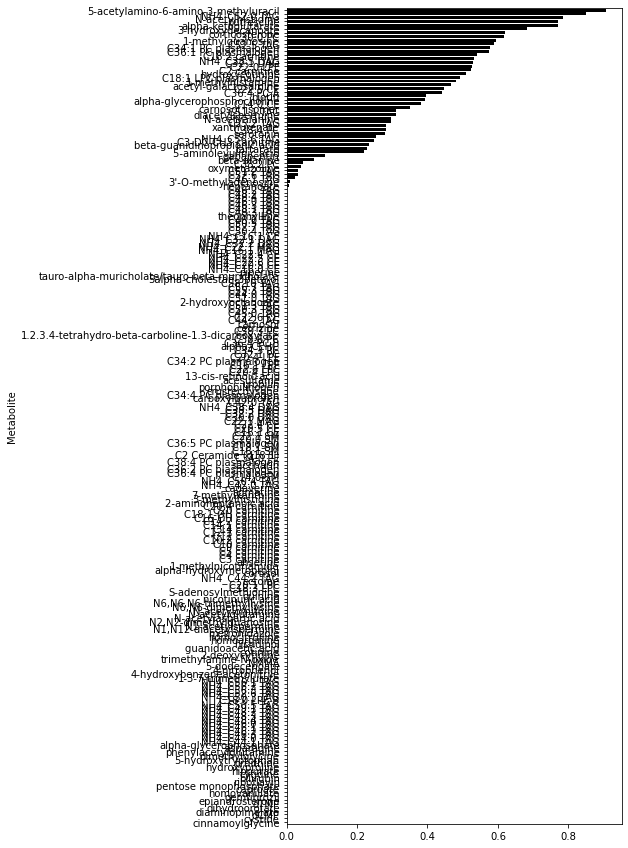

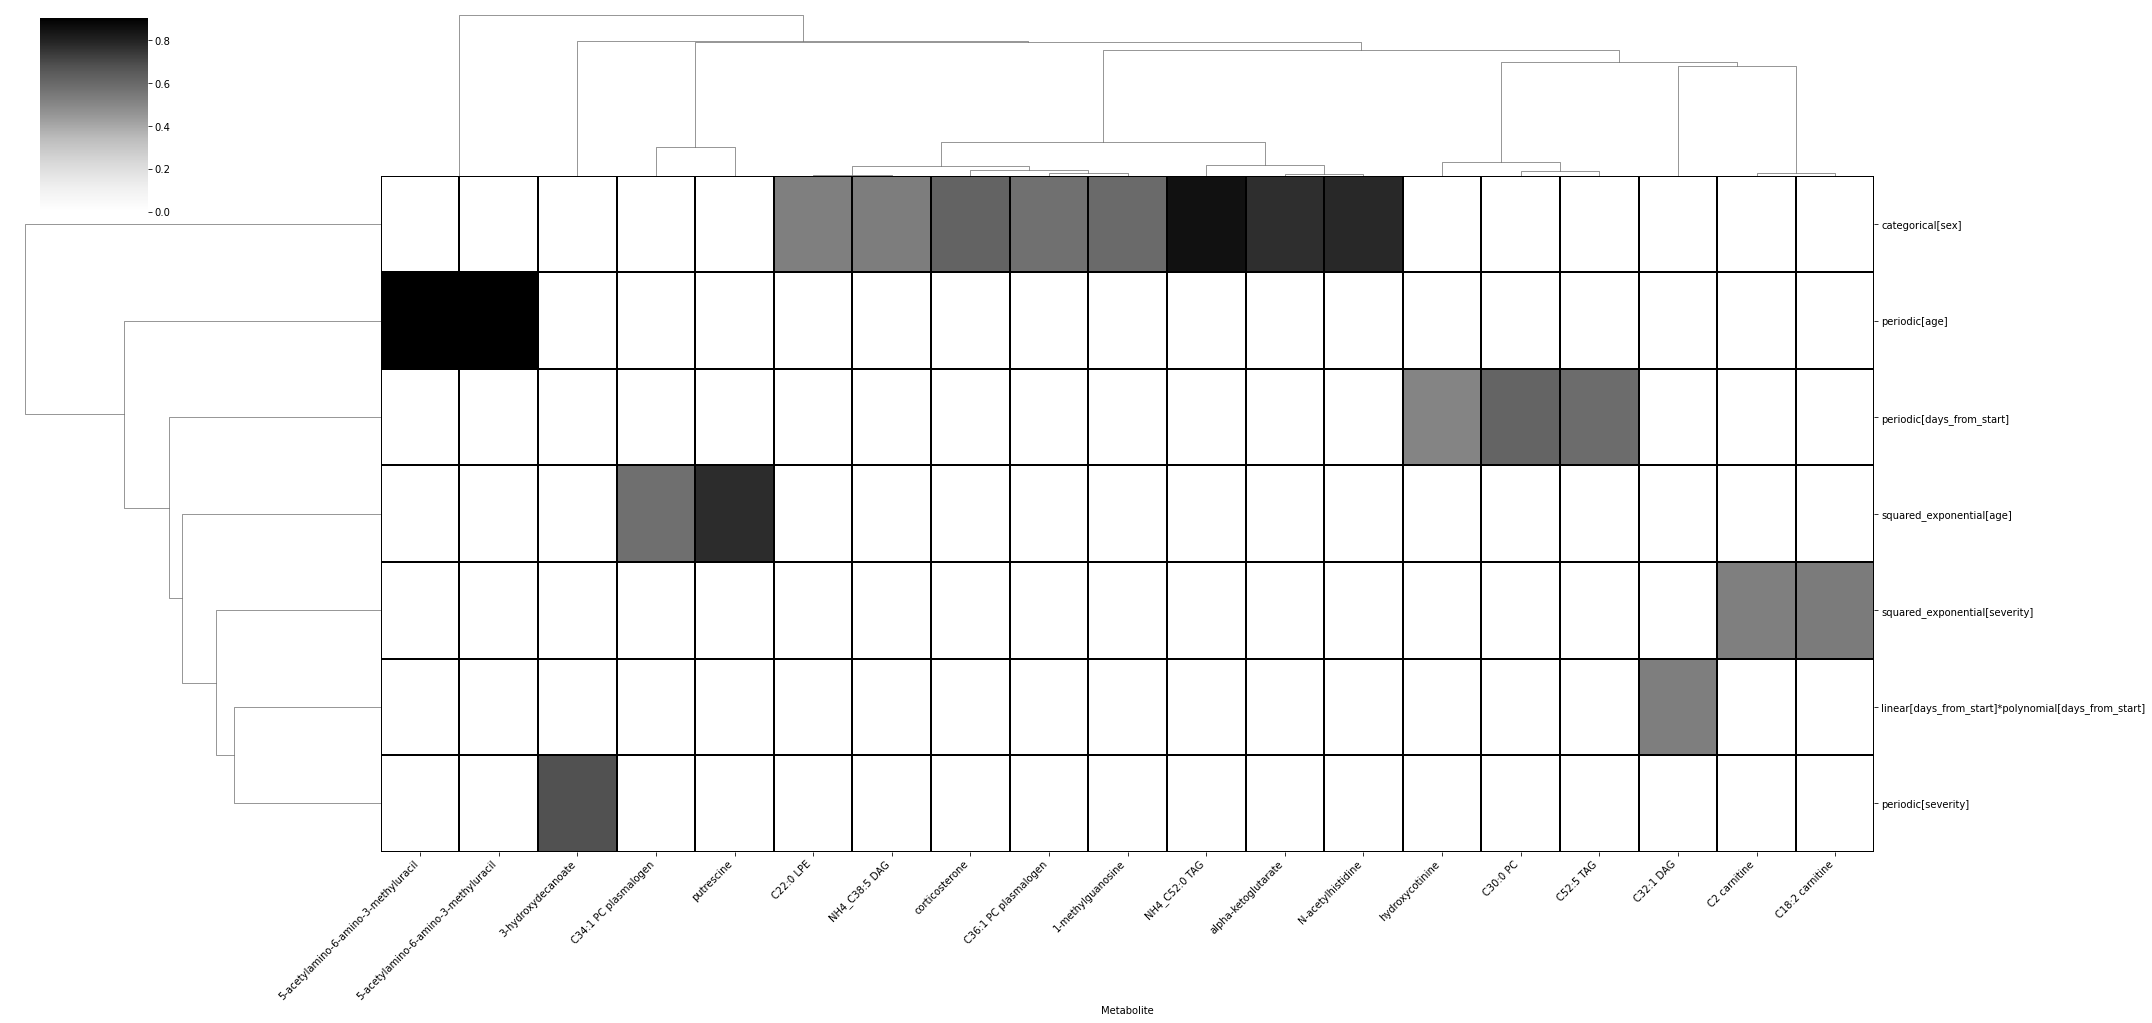

In [12]:
var_explained = [1-(x['var_exp'][-1]/sum(x['var_exp'])) if sum(x['var_exp'])>0 else 0 for x in binomial_models]
var_components = [x['var_exp'] for x in binomial_models]
var_percent = [[y/sum(x) if sum(x) > 0 else 0 for y in x][:-1] for x in var_components]

# Barplot of variance explained
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(
    x=[var_explained[x] for x in np.argsort(var_explained)[::-1]], 
    y=missing_mbx_list[:n_met][np.argsort(var_explained)[::-1]],
    color='black',
)

kernels = [x['best_model'].split('+') for x in binomial_models]
distinct_kernels = np.unique([item for sublist in kernels for item in sublist])
kernel_array = np.zeros(shape=(len(kernels), len(distinct_kernels)))
kernel_idxs = np.vstack([sum([np.where(distinct_kernels==y, 1, 0) for y in x])
                         for x in kernels])

# Just fill in indicators now
kernel_array[kernel_idxs == 1] = [x for y in var_percent for x in y]
kernel_array_filtered = kernel_array[kernel_array.sum(axis=1) > 0.5, :]
kernel_array_filtered2 = kernel_array_filtered[:, kernel_array_filtered.sum(axis=0) > 0]

distinct_kernel_names = distinct_kernels.copy()
distinct_kernel_names = distinct_kernel_names[kernel_array_filtered.sum(axis=0) > 0]
for i, c in enumerate(['['+x+']' for x in feat_names]):
    distinct_kernel_names = [x.replace('['+str(i)+']', c) for x in distinct_kernel_names]

clm = sns.clustermap(pd.DataFrame(kernel_array_filtered2, 
                            index=missing_mbx_list[:n_met][kernel_array.sum(axis=1) > 0.5], 
                            columns=distinct_kernel_names).transpose(),
              figsize=(30, 15),
              cmap='Greys',
              linecolor='black',
              linewidths=1.5,
              #annot=True
                    )
plt.setp(clm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right');
# for t in clm.ax_heatmap.texts:
#     if float(t.get_text())>0:
#         t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
#     else:
#         t.set_text("") # if not it sets an empty text

In [14]:
feat_names 

['id',
 'race',
 'sex',
 'age',
 'severity',
 'days_from_start',
 'days_from_max_severity']

Best kernel: categorical[2]+linear[5]*polynomial[5]


/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


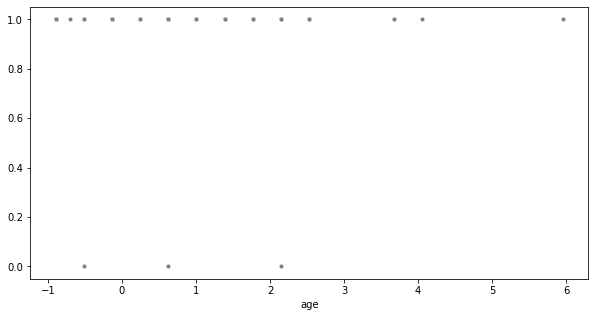

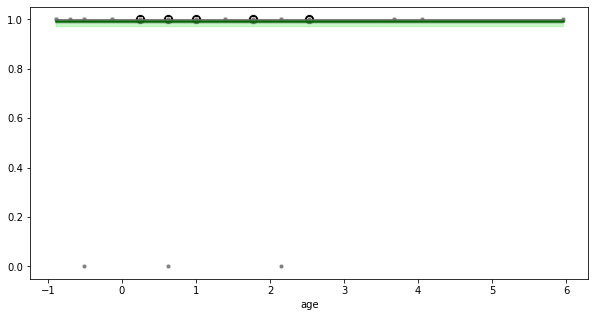

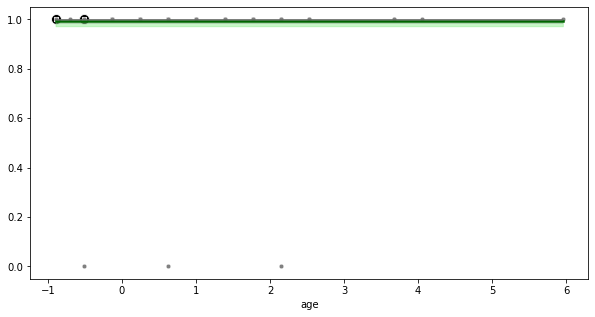

In [16]:
# carboxyibuprofen, cetrizine
mbx_idx = np.argwhere([x == 'NH4_C52:0 TAG' for x in missing_mbx_list]).tolist()[0][0]
cur_metabolite = missing_mbx_list[mbx_idx] 
cur_kernel = binomial_models[mbx_idx]['best_model'] 

print(f'Best kernel: {cur_kernel}')

gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=3, 
    unit_idx=0,
    unit_label=None,
    col_names=feat_names
);

gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=3, 
    unit_idx=0,
    unit_label=1,
    col_names=feat_names
);


gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=3, 
    unit_idx=0,
    unit_label=2,
    col_names=feat_names
);

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


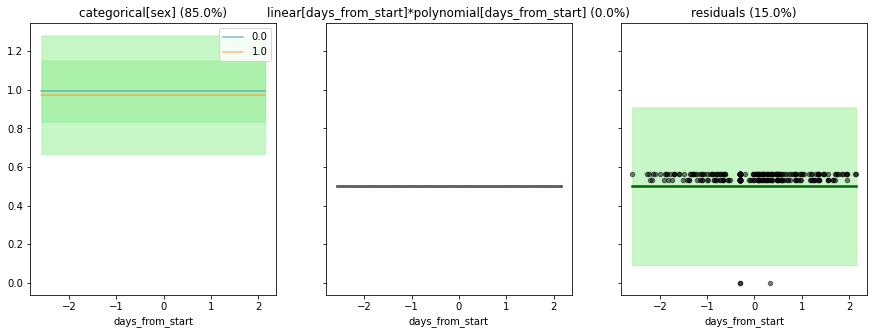

In [18]:
pred_kernel_parts(
    m=binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    k_names=cur_kernel,
    time_idx=5,
    unit_idx=0,
    lik='bernoulli',
    col_names=feat_names
);

Best kernel: categorical[2]+periodic[3]


/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


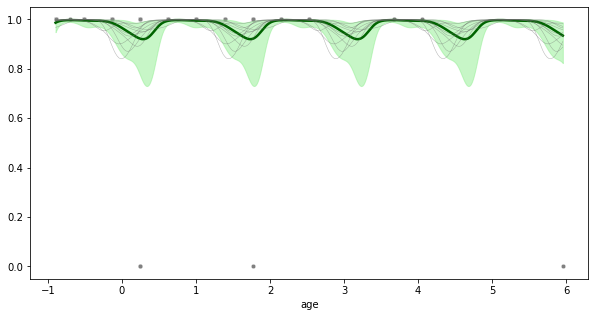

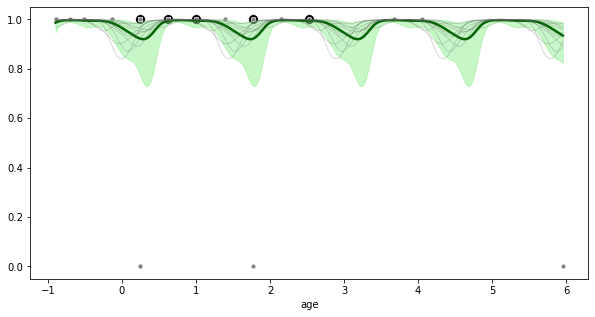

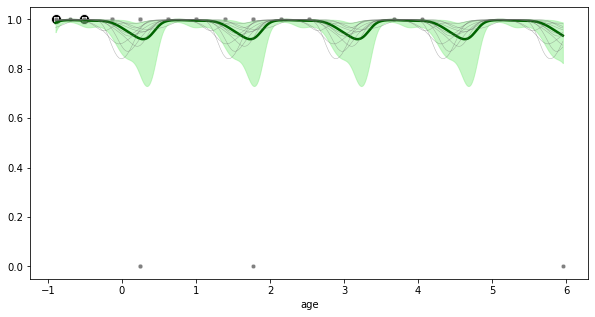

In [22]:
# carboxyibuprofen, cetrizine
mbx_idx = np.argwhere([x == "5-acetylamino-6-amino-3-methyluracil" for x in missing_mbx_list]).tolist()[0][0]
cur_metabolite = missing_mbx_list[mbx_idx] 
cur_kernel = binomial_models[mbx_idx]['best_model'] 

print(f'Best kernel: {cur_kernel}')

gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=3, 
    unit_idx=0,
    unit_label=None,
    col_names=feat_names
);

gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=3, 
    unit_idx=0,
    unit_label=1,
    col_names=feat_names
);


gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=3, 
    unit_idx=0,
    unit_label=2,
    col_names=feat_names
);

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


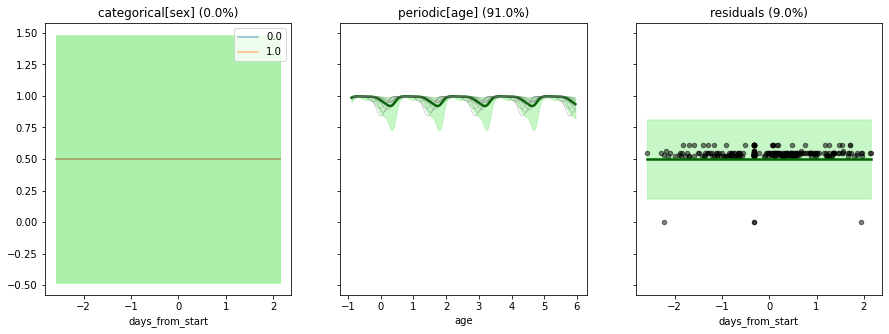

In [23]:
pred_kernel_parts(
    m=binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    k_names=cur_kernel,
    time_idx=5,
    unit_idx=0,
    lik='bernoulli',
    col_names=feat_names
);

In [105]:
binomial_models[mbx_idx]['models'][cur_kernel]['model']

<gpflow.models.vgp.VGP object at 0x2df2a04c0>
╒════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════════╤═════════╤═══════════════════════════╕
│ name                           │ class     │ transform      │ prior   │ trainable   │ shape         │ dtype   │ value                     │
╞════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════════╪═════════╪═══════════════════════════╡
│ VGP.kernel.kernels[0].variance │ Parameter │ Softplus       │ Gamma   │ True        │ ()            │ float64 │ 4.543622003845468e-24     │
├────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼───────────────────────────┤
│ VGP.kernel.kernels[1].variance │ Parameter │ Softplus       │ Gamma   │ True        │ ()            │ float64 │ 2.4000078516192085        │
├────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼───────────────────────────┤
│ VGP.q_mu                       │ Parameter │ Identity       │ Gamma   │ True        │ (392, 1)      │ float64 │ [[1.46310314...           │
├────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────────┼─────────┼───────────────────────────┤
│ VGP.q_sqrt                     │ Parameter │ FillTriangular │ Gamma   │ True        │ (1, 392, 392) │ float64 │ [[[-0.18593801, 0., 0.... │
╘════════════════════════════════╧═══════════╧════════════════╧═════════╧═════════════╧═══════════════╧═════════╧═══════════════════════════╛

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


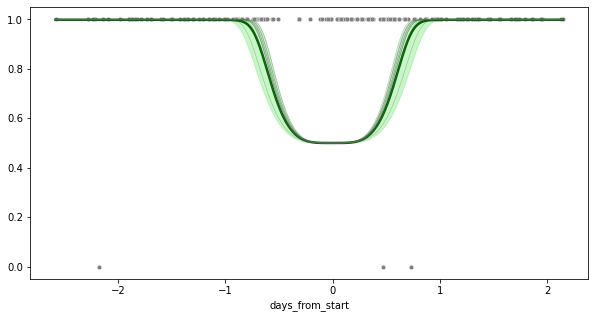

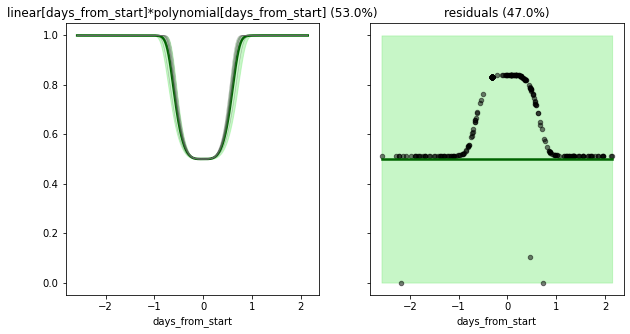

In [26]:
mbx_idx = np.argwhere([x == "C32:1 DAG" for x in missing_mbx_list]).tolist()[0][0]
cur_metabolite = missing_mbx_list[mbx_idx] 
cur_kernel = binomial_models[mbx_idx]['best_model'] 

gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    x_idx=5, 
    unit_idx=0,
    unit_label=None,
    col_names=feat_names
);

pred_kernel_parts(
    m=binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    k_names=cur_kernel,
    time_idx=5,
    unit_idx=0,
    lik='bernoulli',
    col_names=feat_names
);

Now lets see if we can fit one of these final models with an MCMC method for a full posterior.

### Stage One Load

In [12]:
feat_names

['id', 'race', 'sex', 'severity', 'days_from_start', 'days_from_max_severity']

In [3]:
# Load output if needed
binomial_models = pickle.load(open("ihmp_binomial_models.pkl", "rb" ))
binomial_dict = {k: v for k,v in zip(missing_mbx_list, binomial_models)}

# Load into GPKS object
stage1 = GPKernelSearch(
    X=df[feat_names],
    Y=df[missing_mbx_list.unique()],
    unit_col='id',
    categorical_vars=['id', 'race', 'sex'],
    outcome_likelihood="binomial"
)

stage1.models = binomial_dict

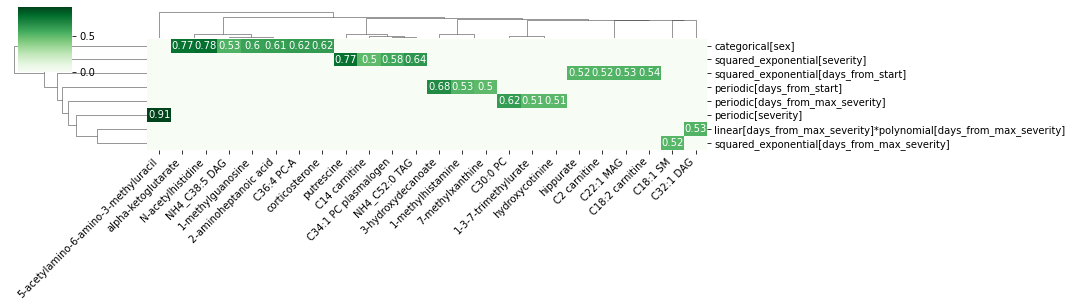

In [4]:
stage1.plot_heatmap(var_cutoff=0.5)

In [32]:
stage1.models["heptanoate"]["models"]["linear[5]*polynomial[4]"]["model"].data[0]

<tf.Tensor: shape=(257, 6), dtype=float64, numpy=
array([[ 0.        ,  0.        ,  0.        ,  0.62697802, -1.85418159,
        -2.21841827],
       [ 0.        ,  0.        ,  0.        ,  0.24649785, -1.57531125,
        -1.82476219],
       [ 0.        ,  0.        ,  0.        ,  0.24649785, -1.26656195,
        -1.38892869],
       ...,
       [49.        ,  0.        ,  1.        , -0.89494265,  1.58189935,
        -0.61567569],
       [49.        ,  0.        ,  1.        , -0.13398232,  1.79603193,
        -0.31340406],
       [49.        ,  0.        ,  1.        , -0.51446248,  2.24919622,
         0.32628705]])>

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'linear[days_from_max_severity]*polynomial[days_from_start] (1.0%)'}, xlabel='days_from_max_severity'>,
        <AxesSubplot:title={'center':'residuals (99.0%)'}, xlabel='days_from_start'>],
       dtype=object))

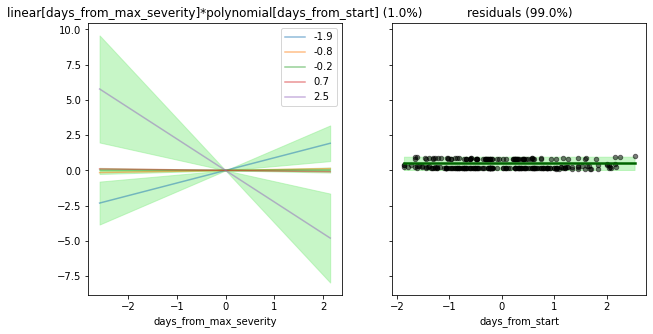

In [7]:
stage1.plot_parts(out_label="heptanoate", x_axis_label="days_from_start")

## iHMP Stage Two Model Search

In [16]:
feat_names = ['id', 'race', 
              'sex', 'age', 'severity', 
              'days_from_start', 
              'days_from_max_severity']

# Standardize the metabolite values
standardized_df = (np.log(df) - np.log(df).mean())/np.log(df).std()

gp_search = GPKernelSearch(
    X=df[feat_names],
    Y=standardized_df.drop(columns=feat_names).iloc[:, :12],
    unit_col='id',
    categorical_vars=['id', 'race', 'sex']
)

search_out = gp_search.run_search(
    kernels=[gpflow.kernels.SquaredExponential(),
             gpflow.kernels.Linear()],
    num_jobs=4
)

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
Kernel search: 100%|███████████████████████████████████████████████████████████████| 12/12 [03:53<00:00, 19.45s/it]


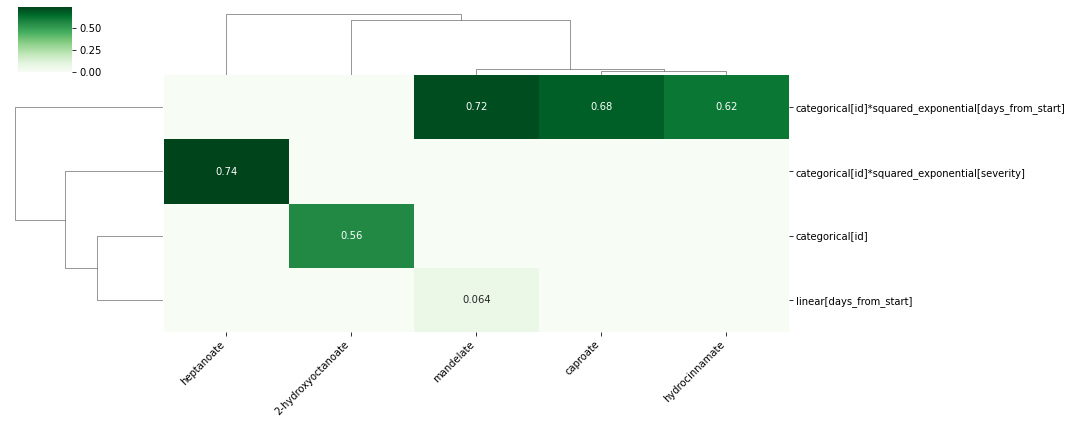

In [28]:
gp_search.plot_heatmap(var_cutoff=0.5)

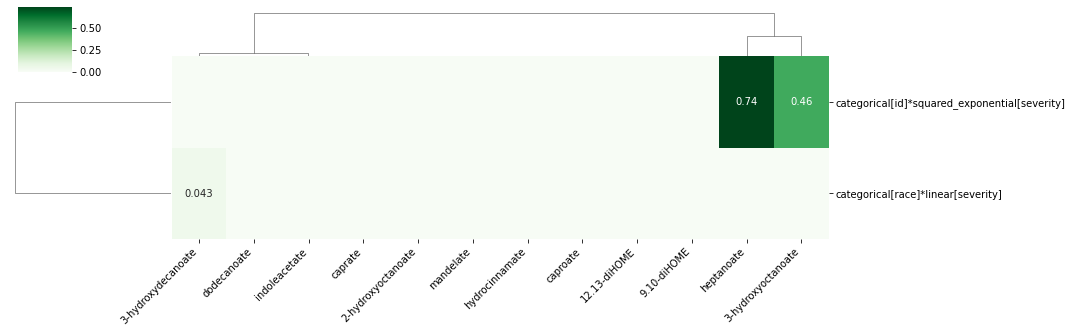

In [30]:
gp_search.plot_heatmap(var_cutoff=0, feat="severity")

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*squared_exponential[severity] (74.0%)'}, xlabel='severity'>,
        <AxesSubplot:title={'center':'residuals (26.0%)'}, xlabel='severity'>],
       dtype=object))

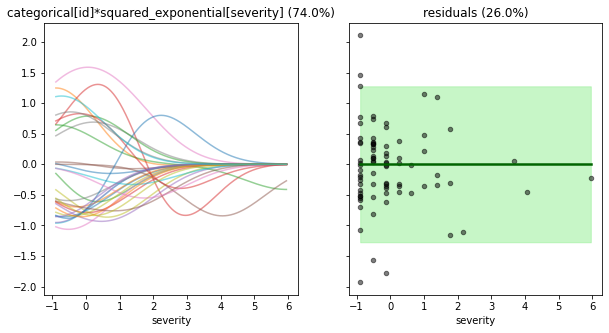

In [19]:
# Let's take a closer look at the heptanoate model 
gp_search.plot_parts(
    out_label="heptanoate",
    x_axis_label="severity"
)

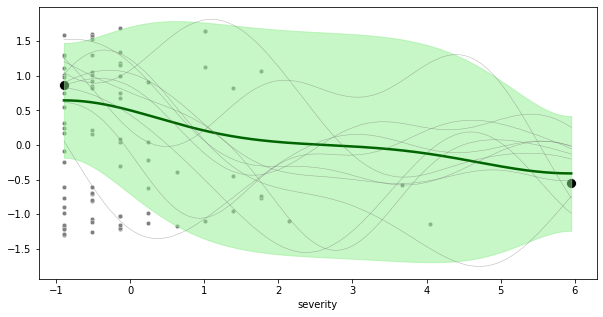

In [27]:
# Let's plot the marginal distribution of heptanoate for a single individual who has the highest reported severity
gp_search.plot_marginal(
    out_label="heptanoate",
    x_axis_label="severity",
    unit_label=20)

In [ ]:
# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               # gpflow.kernels.ArcCosine(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

# Number of metabolites
n_met = len(mbx_list) #9 #30

standardized_df = (np.log(df) - np.log(df).mean())/np.log(df).std()

with tqdm_joblib(tqdm(desc="Kernel search", total=n_met)) as progress_bar:
    gaussian_models = Parallel(n_jobs=-2, verbose=1)(delayed(split_kernel_search)(
            X=df[feat_names],
            Y=standardized_df[[m]],
            kern_list=kernel_list,
            cat_vars=[0, 1, 2, 3],
            unit_idx=0,
            max_depth=5,
            early_stopping=True,
            prune=True,
            keep_all=False,
            lik='gaussian',
            metric_diff=1,
            random_seed=9102)
        for m in mbx_list[:n_met])
    
# Transform list output into dictionary to pull of metabolites of interest
# gaussian_dict = {k: v[0] for k,v in zip(mbx_list[:n_met], gaussian_models)}

# PREVIOUS RUN - 3:22:18 for 587 metabolites

In [8]:
foo = {feat: mod for feat,mod in zip(mbx_list, search_out)}

In [5]:
# Save output
f = open("ihmp_gaussian_models.pkl","wb")
pickle.dump(gaussian_models, f)
f.close()

### Stage Two Load

In [1]:
# Libraries
import pandas as pd
import numpy as np
import gpflow 
import pickle
from helper_functions import *

# Options
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

# Data
# Read in metabolomics data
mbx = pd.read_csv('../examples/iHMP/data/iHMP_labeled_metabolomics.csv')
# Subset metabolites to labeled sets

# Get metabolite list
mbx_list = mbx.Metabolite
# Reshape metabolites for merge
mbx = mbx.iloc[:,7:].transpose().rename(columns = mbx_list)
# Only keep metabolites that have at least 20% non-missing values
mbx_list = mbx_list[(mbx.notna().mean() >= 0.2).values]
mbx = mbx[mbx_list]

# Read in metadata for timing of samples
meta = pd.read_csv('../examples/iHMP/data/iHMP_metadata.csv')
# Subset metadata to appropriate samples and columns of interest
meta = meta[meta['External ID'].isin(mbx.index)][['External ID', 'Participant ID', 
                                                  'date_of_receipt', 'diagnosis',
                                                  'hbi', 'sccai', 'race', 'sex',
                                                  #'Age at diagnosis', 'consent_age',
                                                  #'site_name'
                                                 ]]
meta.set_index('External ID', inplace=True)

# Combine severity scores
meta['severity'] = np.where(meta['diagnosis'] == 'CD', meta.hbi, meta.sccai)
meta['severity'] = np.where(meta['diagnosis'] == 'nonIBD', 0, meta['severity'])

# Make sure that intensities are numeric and log transform them
log_mbx = np.log(mbx.astype('double'))

# Calculate the means and standard deviations of each column
log_means = log_mbx.mean()
log_stds = log_mbx.std()

# Transform dataset
log_mbx = (log_mbx - log_means)/log_stds

# Merge metabolomics info to metadata
df = (meta.merge(mbx, #log_mbx, 
                 left_index = True, 
           right_index = True).
      drop_duplicates().
      rename(columns = {'Participant ID': 'id',
                        'date_of_receipt': 'date'#,
#                         0: 'intensity'
                       }))

# Fix the date column
df.date = pd.to_datetime(df.date)

# Now scale the dates compared to the earliest date
min_date = df.date.min()
df['days_from_start'] = (df.date - min_date).dt.days

# Find the max severity day for each ID
max_date = df[['id', 'severity', 'date']].\
    dropna(subset=['severity']).\
    sort_values(['severity', 'date'], ascending=[True, False]).\
    groupby('id').\
    tail(1).\
    drop(columns=['severity']).\
    rename(columns={'date': 'max_severity_date'})

# Merge to get the median date for controls
max_date = max_date.merge(
    right=df.query("diagnosis == 'nonIBD'")[['id', 'date']].\
        groupby('id', as_index=False).\
        apply(lambda x: x.iloc[int(np.floor((len(x)+1)//2))]).\
        rename(columns={'date': 'med_severity_date'}),
    on='id',
    how='left'
)
# Use median date if available, otherwise use computed value
max_date['max_severity_date'] = max_date.med_severity_date.combine_first(max_date.max_severity_date)
# Drop unnecessary column
max_date.drop(columns=['med_severity_date'], inplace=True)

# Merge this back to df
df = pd.merge(df, max_date, on='id')
df['days_from_max_severity'] = (df.date - df.max_severity_date).dt.days
df = df.drop(columns=['max_severity_date'])

# Drop columns that aren't needed (drop id for the moment)
df = df.drop(columns=['date'])#, 'id'])

# Drop duplicate metabolites
df = df.loc[:,~df.columns.duplicated()]

# Only keep CD observations because they have hbi
# df = df.query("diagnosis == 'CD'").drop(columns = ['diagnosis'])

# Only keep non-missing severity for the moment
# df = df[df.hbi.notna()]

# Fill in severity scores for individuals, last carry forward 
df['severity'] = df[['id', 'severity']].\
    groupby('id').\
    fillna(method='ffill')
df = df[df.severity.notna()]
df = df.drop(columns=['hbi', 'sccai'])

# Drop UC individuals for now
df = df.query("diagnosis != 'UC'")
df = df.query("diagnosis == 'CD'")
df = df.drop(columns=['diagnosis'])

# Store individual information look up vectors
# Get numerics for each categorical value as well as the lookup index
df['id'], id_map = pd.factorize(df['id'])
# df['diagnosis'], diagnosis_map = pd.factorize(df['diagnosis'])
df['race'], race_map = pd.factorize(df['race'])
df['sex'], sex_map = pd.factorize(df['sex'])
# n_id = df.id.nunique()
# id_list = df.id.unique()
# id_vals = df.id.values
# id_idx = np.array([np.where(id_list == x)[0][0] for x in id_vals])
# df['id'] = id_idx

# Only keep metabolites 
df_original = df.copy()

# Standardize severity and days for convergence properties
df.days_from_start = (df.days_from_start - df.days_from_start.mean())/df.days_from_start.std()
df.days_from_max_severity = (df.days_from_max_severity - df.days_from_max_severity.mean())/df.days_from_max_severity.std()
df.severity = (df.severity - df.severity.mean())/df.severity.std()

# Normalize columns
# df.days_from_start = (df.days_from_start.max() - df.days_from_start)/(df.days_from_start.max()-df.days_from_start.min())
# df.hbi = (df.hbi.max() - df.hbi)/(df.hbi.max() - df.hbi.min())
# df.id = (df.id.max() - df.id)/(df.id.max() - df.id.min())
# df.id = (df.id - df.id.mean())/df.id.std()
print(df.shape)
df.head()

# Specify the covariate features of interest
feat_names = col_names = ['id', # 'diagnosis', 
                          'race', 'sex', 
                          'severity', 
                          'days_from_start', 
                          'days_from_max_severity']
df.shape

# Get percent missing for each column and then only flag metabolites with at least 1% observations missing
missing_df = df[mbx_list].isna().mean()
missing_mbx_list = mbx_list[(missing_df>=0.01).values].reset_index(drop=True)

# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               # gpflow.kernels.ArcCosine(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

# Number of metabolites
n_met = len(missing_mbx_list)

/var/folders/2w/r7x976td4f97twg4r5ff50500000gn/T/ipykernel_57373/114640039.py:27: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('../examples/iHMP/data/iHMP_metadata.csv')


(257, 550)


In [2]:
df.head()

id  race  sex  severity  12.13-diHOME  9.10-diHOME  caproate  heptanoate  \
0   0     0    0  0.626978      942546.0    1418451.0    2194.0         NaN   
1   0     0    0  0.246498      584730.0    1955625.0    2305.0         NaN   
2   0     0    0  0.246498      555437.0     739486.0     670.0         NaN   
3   0     0    0  0.626978      937676.0    1002635.0    1295.0         NaN   
4   0     0    0  1.768419     1286163.0    1453551.0    2920.0         NaN   

   hydrocinnamate  mandelate  ...  C18:1 LPC plasmalogen  C18:0 LPE-A  \
0         38180.0     5893.0  ...               453688.0    9997928.0   
1         69475.0    10406.0  ...               130737.0   16335239.0   
2          9780.0     6117.0  ...                 3760.0    4371214.0   
3         17147.0     9764.0  ...                18460.0    3306645.0   
4         23123.0     6514.0  ...                    NaN    8323839.0   

   C18:0 LPE-B   C22:6 LPE  sphingosine-isomer1  sphingosine-isomer2  \
0    3579319.0   2066660.0          274385476.0          136360623.0   
1   13177075.0   4447184.0          121055143.0           65245288.0   
2    2130907.0  10511485.0          199161782.0          106462063.0   
3    2323331.0   1555152.0          187973992.0           97169686.0   
4    2529248.0   4901090.0          152639719.0           79560140.0   

   sphingosine-isomer3  C14:0 SM  days_from_start  days_from_max_severity  
0          211906815.0   36328.0        -1.854182               -2.218418  
1          301546342.0   51577.0        -1.575311               -1.824762  
2          118183128.0       NaN        -1.266562               -1.388929  
3           72151914.0       NaN        -0.858216               -0.812504  
4          225812346.0    6212.0        -0.504648               -0.313404  

[5 rows x 550 columns]

In [9]:
# Load output if needed
gaussian_models = pickle.load(open("ihmp_gaussian_models.pkl", "rb" ))
gaussian_dict = {k: v for k,v in zip(mbx_list, gaussian_models)}

In [10]:
stage2 = GPKernelSearch(
    X=df[feat_names],
    Y=df.drop(columns=feat_names),
    unit_col='id',
    categorical_vars=['id', 'race', 'sex']
)

stage2.models = gaussian_dict

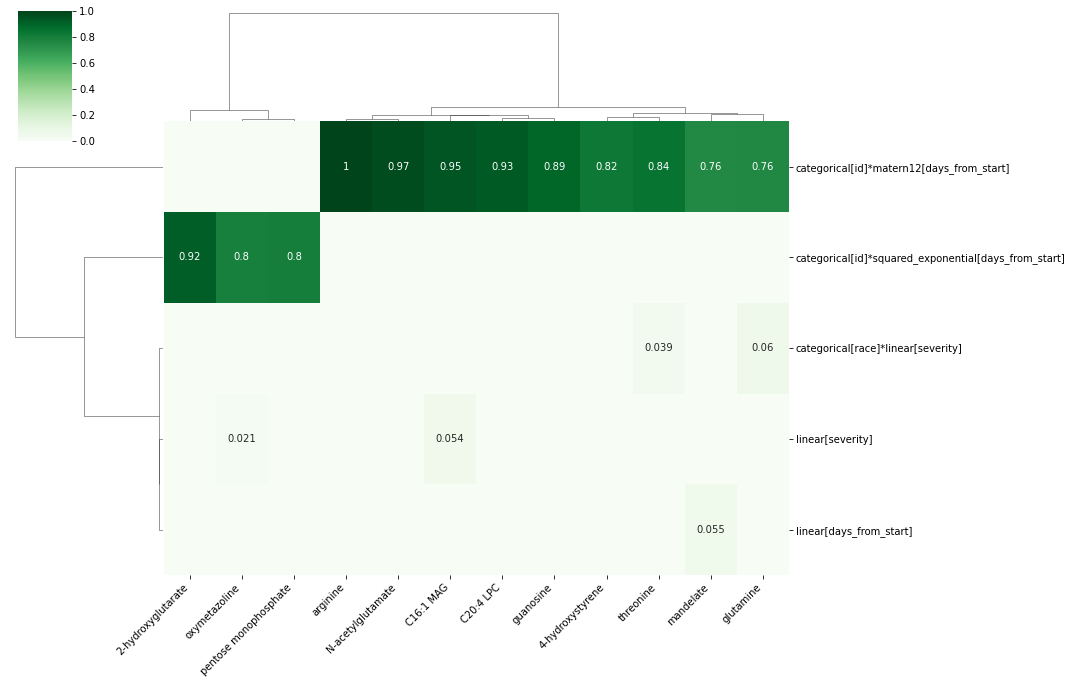

In [24]:
stage2.plot_heatmap(var_cutoff=0.8, show_vals=True, figsize=(15, 10))

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*matern12[days_from_start] (100.0%)'}, xlabel='days_from_start'>,
        <AxesSubplot:title={'center':'residuals (0.0%)'}, xlabel='days_from_start'>],
       dtype=object))

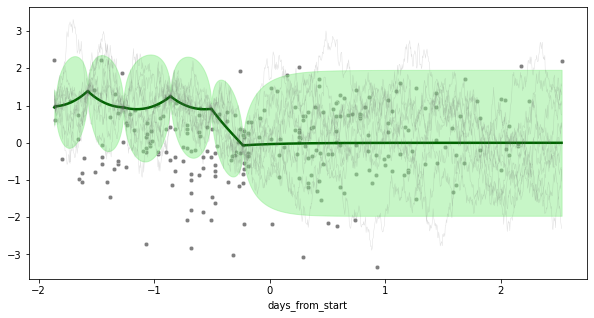

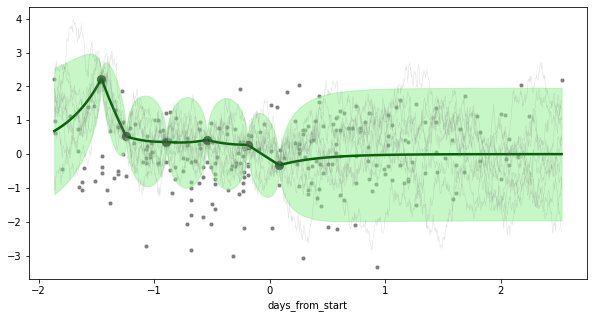

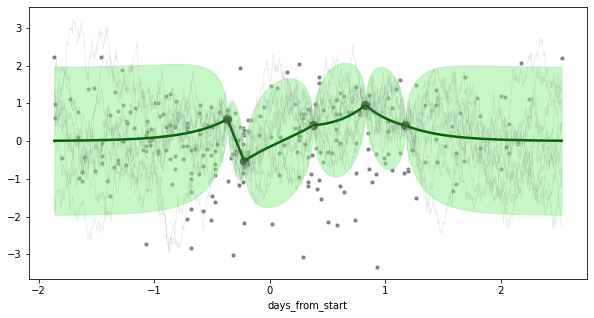

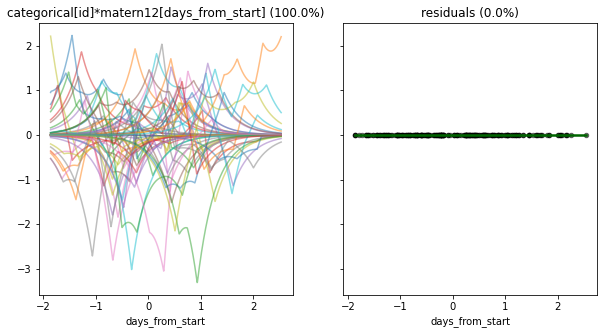

In [26]:
# What does this look like for a time-varying metabolite?
stage2.plot_marginal(out_label="arginine", x_axis_label="days_from_start")
stage2.plot_marginal(out_label="arginine", x_axis_label="days_from_start", unit_label=20)
stage2.plot_marginal(out_label="arginine", x_axis_label="days_from_start", unit_label=10)
stage2.plot_parts(out_label="arginine", x_axis_label="days_from_start")

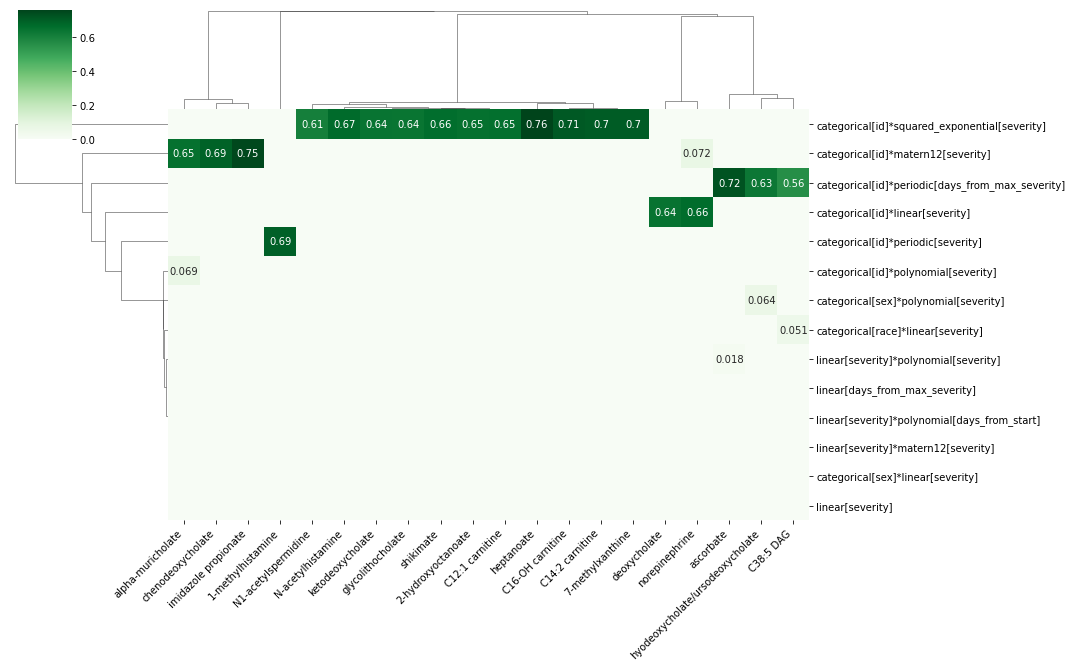

In [9]:
# Let's focus now on disease severity
stage2.plot_heatmap(var_cutoff=0.6, feat="severity", figsize=(15, 10))

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


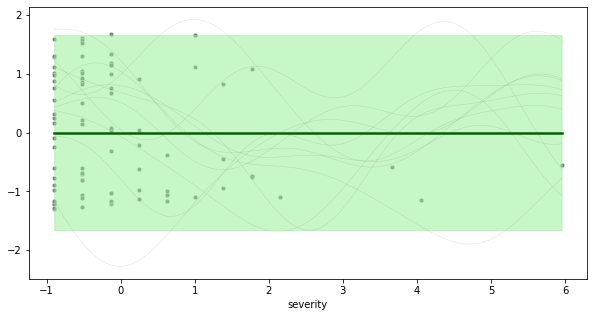

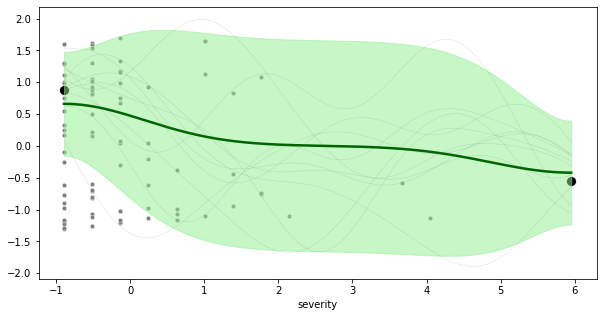

In [12]:
stage2.plot_marginal(out_label="heptanoate", x_axis_label="severity")
stage2.plot_marginal(out_label="heptanoate", x_axis_label="severity", unit_label=20)

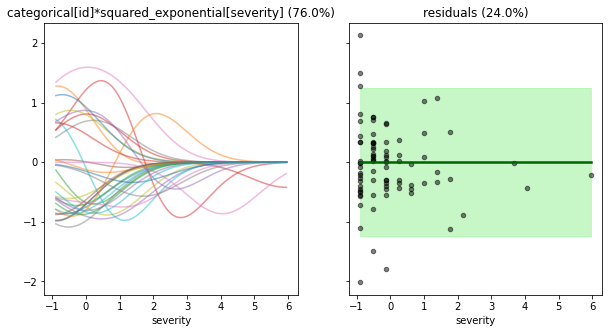

In [14]:
stage2.plot_parts(out_label="heptanoate", x_axis_label="severity");

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


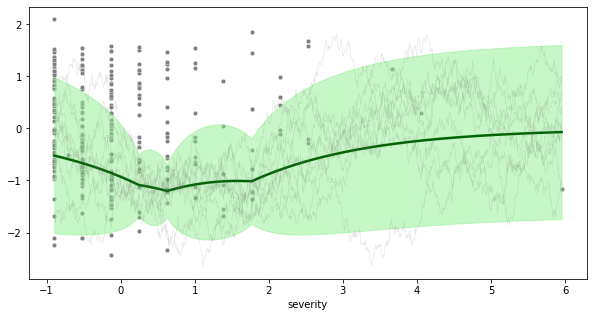

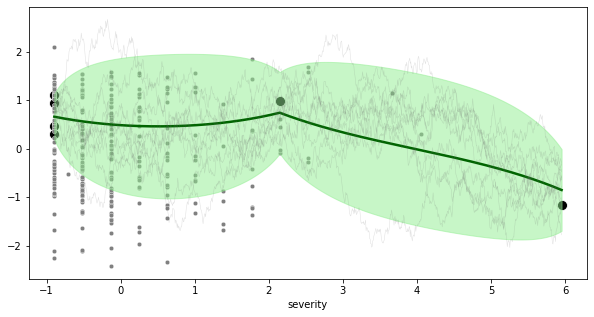

In [12]:
# What about another metabolite?
stage2.plot_marginal(out_label="imidazole propionate", x_axis_label="severity")
stage2.plot_marginal(out_label="imidazole propionate", x_axis_label="severity", unit_label=20)

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*matern12[severity] (75.0%)'}, xlabel='severity'>,
        <AxesSubplot:title={'center':'residuals (25.0%)'}, xlabel='severity'>],
       dtype=object))

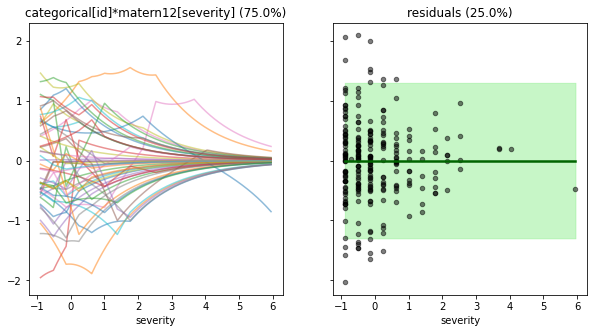

In [13]:
stage2.plot_parts(out_label="imidazole propionate", x_axis_label="severity")

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*periodic[days_from_max_severity] (72.0%)'}, xlabel='days_from_max_severity'>,
        <AxesSubplot:title={'center':'linear[severity]*polynomial[severity] (2.0%)'}, xlabel='severity'>,
        <AxesSubplot:title={'center':'residuals (26.0%)'}, xlabel='days_from_max_severity'>],
       dtype=object))

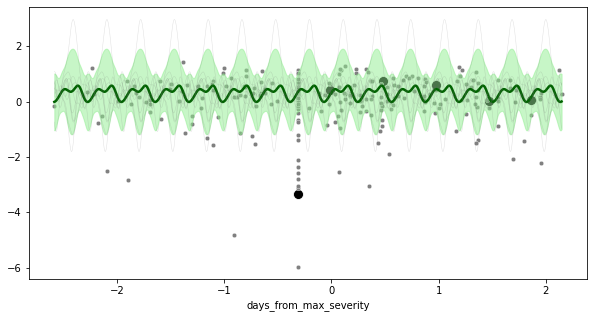

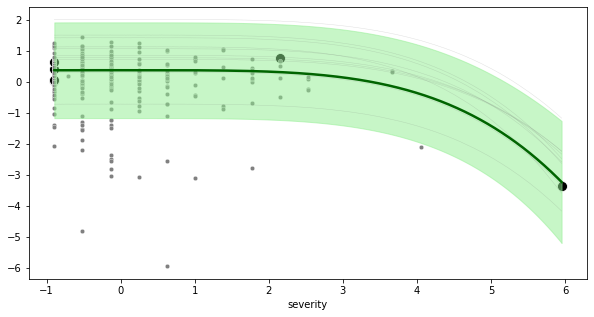

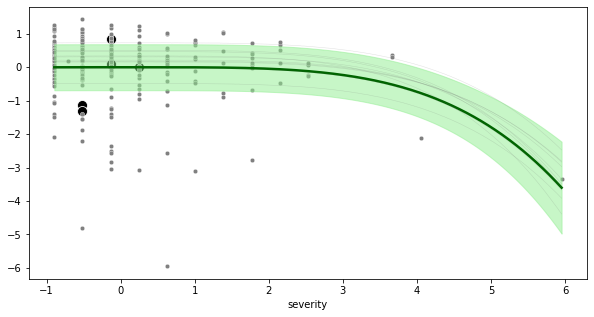

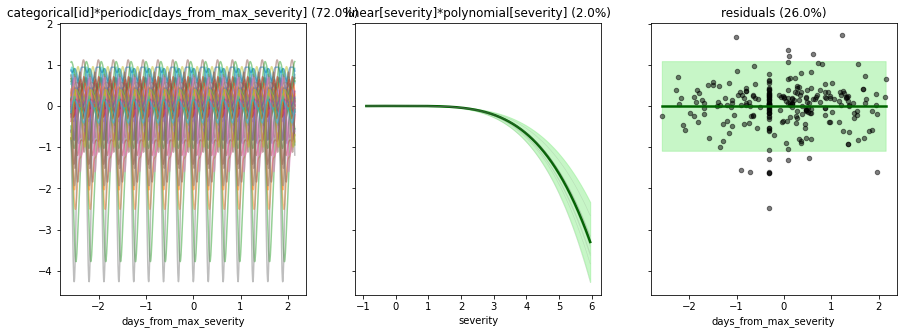

In [22]:
# How about days from max severity mark?
stage2.plot_marginal(out_label="ascorbate", x_axis_label="days_from_max_severity", unit_label=20)
stage2.plot_marginal(out_label="ascorbate", x_axis_label="severity", unit_label=20)
stage2.plot_marginal(out_label="ascorbate", x_axis_label="severity", unit_label=10)
stage2.plot_parts(out_label="ascorbate", x_axis_label="days_from_max_severity")

KeyError: '[485, 369, 68, 411, 354, 572, 364, 70, 71] not in index'

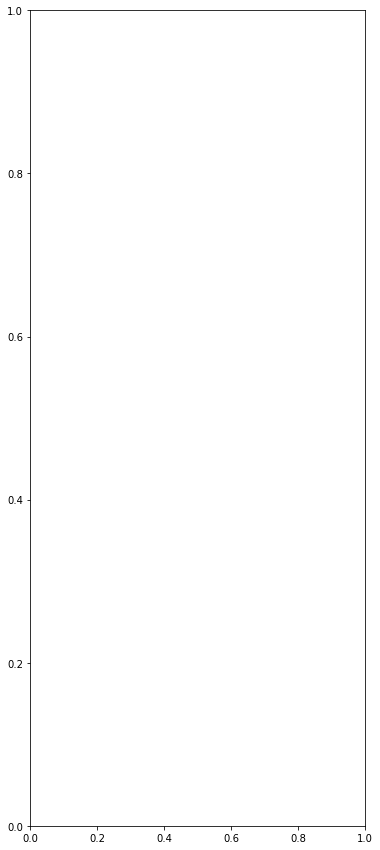

In [51]:
var_explained = [1-(x['var_exp'][-1]/sum(x['var_exp'])) if sum(x['var_exp'])>0 else 0 for x in gaussian_models]
var_components = [x['var_exp'] for x in gaussian_models]
var_percent = [[y/sum(x) if sum(x) > 0 else 0 for y in x][:-1] for x in var_components]

# Barplot of variance explained
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(
    x=[var_explained[x] for x in np.argsort(var_explained)[::-1]], 
    y=mbx_list[np.argsort(var_explained)[::-1]],
    color='black',
)

kernels = [x['best_model'].split('+') for x in binomial_models]
distinct_kernels = np.unique([item for sublist in kernels for item in sublist])
kernel_array = np.zeros(shape=(len(kernels), len(distinct_kernels)))
kernel_idxs = np.vstack([sum([np.where(distinct_kernels==y, 1, 0) for y in x])
                         for x in kernels])

# Just fill in indicators now
kernel_array[kernel_idxs == 1] = [x for y in var_percent for x in y]
kernel_array_filtered = kernel_array[kernel_array.sum(axis=1) > 0.5, :]
kernel_array_filtered2 = kernel_array_filtered[:, kernel_array_filtered.sum(axis=0) > 0]

distinct_kernel_names = distinct_kernels.copy()
distinct_kernel_names = distinct_kernel_names[kernel_array_filtered.sum(axis=0) > 0]
for i, c in enumerate(['['+x+']' for x in feat_names]):
    distinct_kernel_names = [x.replace('['+str(i)+']', c) for x in distinct_kernel_names]

clm = sns.clustermap(pd.DataFrame(kernel_array_filtered2, 
                            index=missing_mbx_list[:n_met][kernel_array.sum(axis=1) > 0.5], 
                            columns=distinct_kernel_names).transpose(),
              figsize=(30, 15),
              cmap='Greys',
              linecolor='black',
              linewidths=1.5,
              #annot=True
                    )
plt.setp(clm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right');

In [35]:
best_model_name = 'categorical[0]*periodic[3]'
best_model = stage2.models['1-methylhistamine']['models']['categorical[0]*periodic[3]']['model']

In [29]:
kernel_names = best_model_name.split('+')
'*' in kernel_names[0]

True

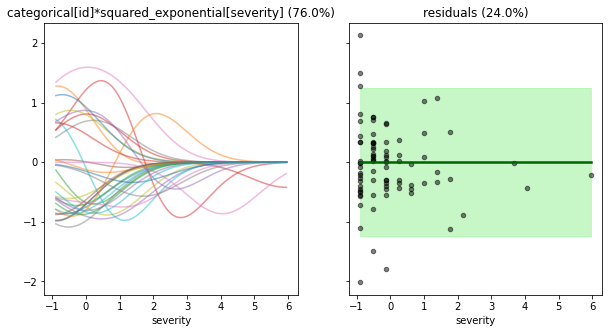

In [6]:
stage2.plot_parts(out_label='heptanoate', x_axis_label='severity');

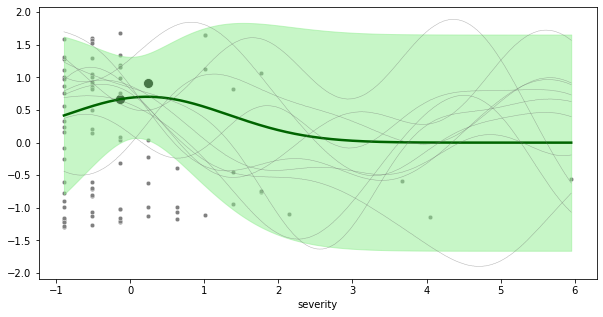

In [7]:
stage2.plot_marginal(out_label='heptanoate', x_axis_label='severity', unit_label=10);

In [50]:
gaussian_dict = {k: v for k,v in zip(mbx_list, gaussian_models)}

In [52]:
gaussian_dict[cur_metabolite]['best_model']

'categorical[0]*matern12[4]'

In [53]:
gaussian_dict[cur_metabolite]['models'][gaussian_dict[cur_metabolite]['best_model']]['model']

<gpflow.models.gpr.GPR object at 0x2c93a1970>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 1.00039     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │ Gamma   │ False       │ ()      │ float64 │ 1           │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.344751    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │ Gamma   │ True        │ ()      │ float64 │ 3.35841e-06 │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════╛

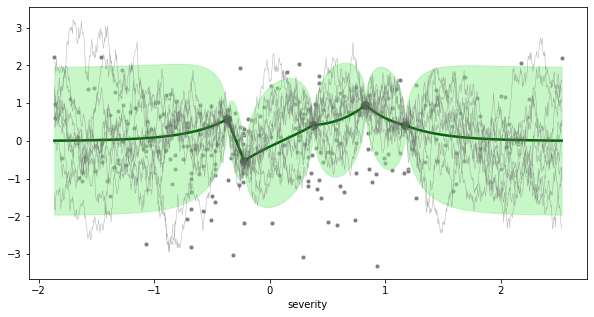

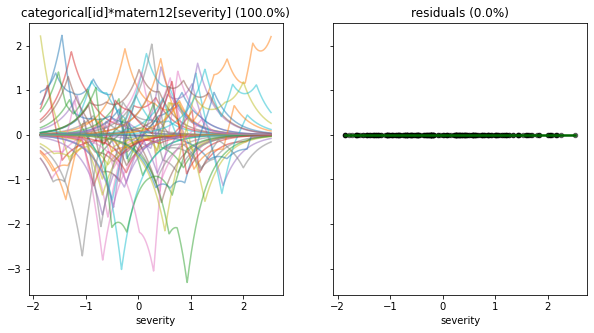

In [51]:
cur_metabolite = 'arginine'

gp_predict_fun(
    gp=gaussian_dict[cur_metabolite]['models'][gaussian_dict[cur_metabolite]['best_model']]['model'],
    x_idx=4,
    unit_idx=0,
    col_names=feat_names,
    unit_label=10
)

pred_kernel_parts(
    m=gaussian_dict[cur_metabolite]['models'][gaussian_dict[cur_metabolite]['best_model']]['model'],
    k_names=gaussian_dict[cur_metabolite]['best_model'],
    time_idx=4,
    unit_idx=0,
    col_names=feat_names
);

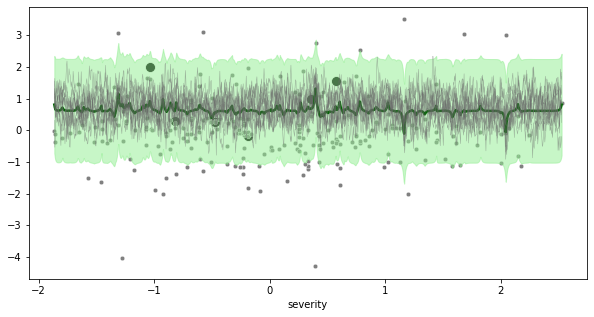

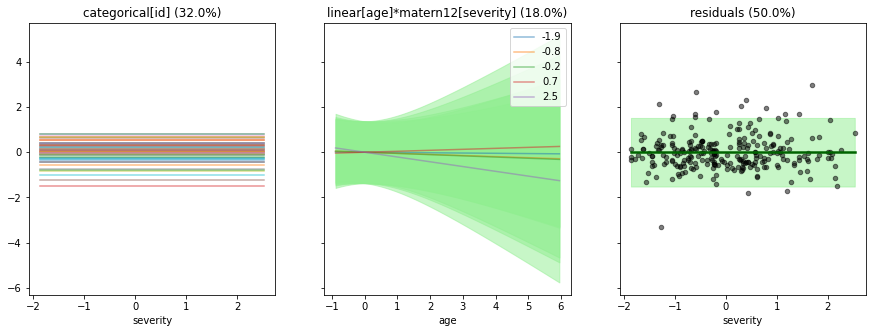

In [43]:
cur_metabolite = 'C44:1 TAG'

gp_predict_fun(
    gp=gaussian_dict[cur_metabolite]['models'][gaussian_dict[cur_metabolite]['best_model']]['model'],
    x_idx=4,
    unit_idx=0,
    col_names=feat_names,
    unit_label=5
)

pred_kernel_parts(
    m=gaussian_dict[cur_metabolite]['models'][gaussian_dict[cur_metabolite]['best_model']]['model'],
    k_names=gaussian_dict[cur_metabolite]['best_model'],
    time_idx=4,
    unit_idx=0,
    col_names=feat_names
);

In [55]:
gaussian_dict[cur_metabolite]['models'][gaussian_dict[cur_metabolite]['best_model']]['model']

<gpflow.models.gpr.GPR object at 0x16a2f9040>
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].variance                │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.390784 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.164898 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].kernels[0].lengthscales │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.398813 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].kernels[1].variance     │ Parameter │ Softplus         │ Gamma   │ False       │ ()      │ float64 │ 1        │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance                       │ Parameter │ Softplus + Shift │ Gamma   │ True        │ ()      │ float64 │ 0.444087 │
╘═══════════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧══════════╛

In [30]:
stage2.models['C24:0 SM']['models']['categorical[0]+linear[4]*squared_exponential[4]']['model']

<gpflow.models.gpr.GPR object at 0x2b74d5760>
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].variance                │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.390784 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].kernels[0].variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.164898 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].kernels[0].lengthscales │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.398813 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].kernels[1].variance     │ Parameter │ Softplus         │ Gamma   │ False       │ ()      │ float64 │ 1        │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance                       │ Parameter │ Softplus + Shift │ Gamma   │ True        │ ()      │ float64 │ 0.444087 │
╘═══════════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧══════════╛

In [ ]:
stage2.models['C24:0 SM']['models']['categorical[0]+linear[4]*squared_exponential[4]']['model'].predict_f()

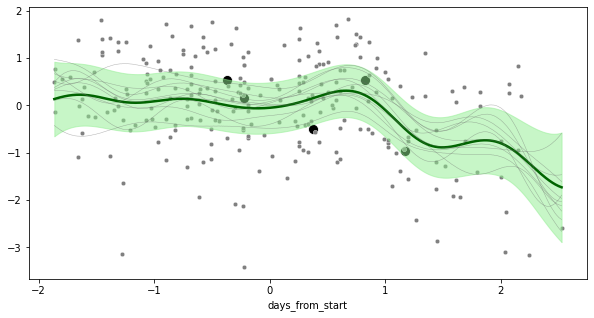

In [8]:
stage2.plot_marginal(out_label='C24:0 SM', x_axis_label='days_from_start', unit_label=10)

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


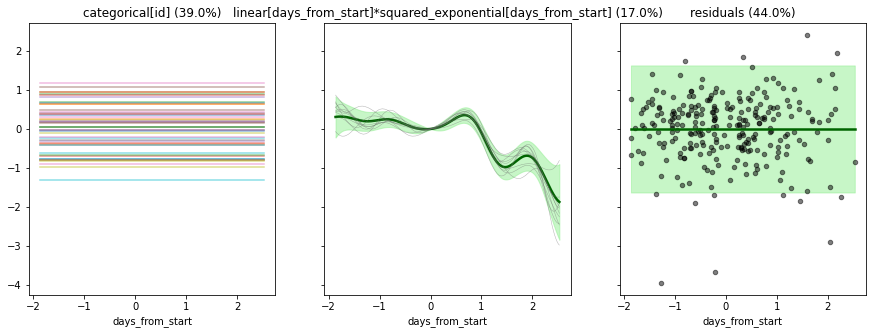

In [9]:
stage2.plot_parts(out_label='C24:0 SM', x_axis_label='days_from_start');

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


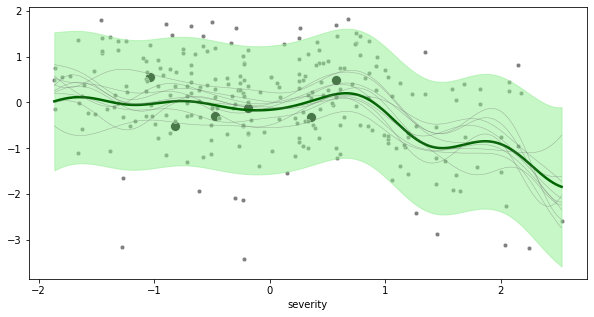

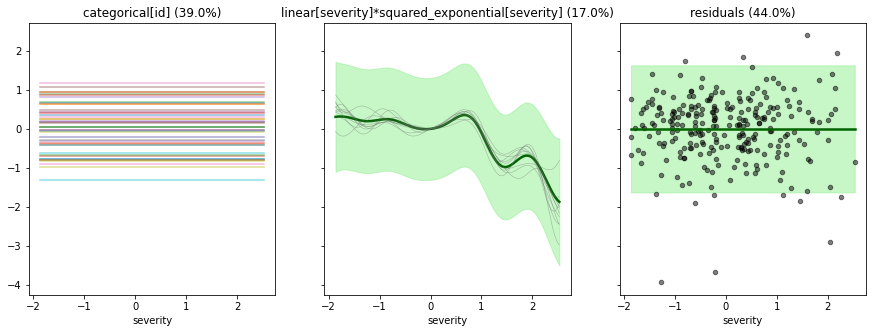

In [54]:
cur_metabolite = 'C24:0 SM'

gp_predict_fun(
    gp=gaussian_dict[cur_metabolite]['models'][gaussian_dict[cur_metabolite]['best_model']]['model'],
    x_idx=4,
    unit_idx=0,
    col_names=feat_names,
    unit_label=5
)

pred_kernel_parts(
    m=gaussian_dict[cur_metabolite]['models'][gaussian_dict[cur_metabolite]['best_model']]['model'],
    k_names=gaussian_dict[cur_metabolite]['best_model'],
    time_idx=4,
    unit_idx=0,
    col_names=feat_names
);

In [10]:
# Can we just look at the top five metabolites with the greatest explained variance?
top_five_idx = np.argsort(var_explained)[::-1][:10]

for m in top_five_idx:
    mbx_idx = m
    cur_metabolite = mbx_list.values[mbx_idx] #'heptanoate'#'ketodeoxycholate'#'17-methylstearate'#'chenodeoxycholate'#'mandelate'#'heptanoate'
    cur_kernel = gaussian_models[mbx_idx]['best_model'] #'categorical[0]+linear[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*linear[2]'
    # observed_data = df[['id', 'hbi', 'days_from_start', cur_metabolite]].dropna()

    print(f"Best kernel: {cur_kernel} for metabolite {cur_metabolite}")

    # # Plot posterior distribution
    # p = gp_predict_fun(
    #     gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    #     # gaussian_dict[cur_metabolite][cur_kernel][1], 
    #     x_idx=2, 
    #     unit_idx=0,
    #     unit_label=5,
    #     col_names=col_names
    # )
    # Print resulting decomposition
    pred_kernel_parts(
        gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
        # gaussian_dict[cur_metabolite][cur_kernel][1],
        cur_kernel,
        time_idx=4,
        unit_idx=0,
        col_names=feat_names
    );

NameError: name 'var_explained' is not defined

### Clustering Output

In [2]:
gaussian_models = pickle.load(open("ihmp_gaussian_models.pkl", "rb" ))

In [3]:
[x['best_model'] for x in gaussian_models[:10]]

['categorical[0]',
 'categorical[0]*squared_exponential[4]',
 'categorical[0]*matern12[5]+categorical[3]*linear[4]',
 'categorical[0]*squared_exponential[5]',
 'categorical[0]*polynomial[4]',
 'categorical[0]*matern12[5]+categorical[1]*linear[4]',
 'categorical[0]+categorical[2]*linear[6]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]']

In [4]:
np.unique([i for s in [x['best_model'].split('+') for x in gaussian_models[:10]] for i in s])

array(['categorical[0]', 'categorical[0]*matern12[5]',
       'categorical[0]*polynomial[4]',
       'categorical[0]*squared_exponential[4]',
       'categorical[0]*squared_exponential[5]',
       'categorical[1]*linear[4]', 'categorical[2]*linear[6]',
       'categorical[3]*linear[4]'], dtype='<U37')

In [5]:
# Go through all fitted models and pull off hyperparameter values
param_list = []
for i in range(len(gaussian_models)):
    # print(i)
    # Grab current kernel
    cur_kern = gaussian_models[i]['models'][gaussian_models[i]['best_model']]['kernel']
    # Check if it has multiple components (or sub kernels of +/*)
    if hasattr(cur_kern, 'kernels'):
        k_done = 0
        sub_group = []
        # If so then go through each sub component
        while k_done < len(cur_kern.kernels):
            if cur_kern.name == 'product':
                sub_group += [x.numpy().item() for x in cur_kern.kernels[k_done].parameters]
            else:
                param_list += [[x.numpy().item() for x in cur_kern.kernels[k_done].parameters]]
            k_done += 1
        # Attach product components together in one group
        if cur_kern.name == 'product':
            param_list += [sub_group]
    # Otherwise there is only one kernel component and therefore just pull of specific value
    else:
        param_list += [[x.numpy().item() for x in cur_kern.parameters]]
    

In [6]:
# Split up kernel names by additive components
kernels = [x['best_model'].split('+') for x in gaussian_models]
# Get individual lengths of each model
kernel_lengths = [len(x) for x in kernels]
# Flatten this list
kernels_sep = [item for sublist in kernels for item in sublist]
# Get number of unique kernel components as columns for parameter array 
distinct_kernels, kernel_idx = np.unique(kernels_sep, return_index=True)
param_lengths = [len(param_list[x]) for x in kernel_idx]
parameter_array = np.zeros(shape=(len(gaussian_models), sum(param_lengths)))

In [7]:
parameter_array.shape

(587, 125)

In [8]:
m_ = 0  # Set model row indicator
cs_param_lengths = np.cumsum(param_lengths)
for i in range(len(param_list)):

    # Figure out if we need to go to the next row in the matrix
    if i == np.cumsum(kernel_lengths)[m_]:
        m_ += 1

    # Get next kernel component
    kern_ = kernels_sep[i]

    # Get kernel lookup information
    k_idx = np.where(kern_ == distinct_kernels)[0].item()

    # Find the length of number of parameters to fill in
    # p_length_ = len(param_list[kernel_idx[k_idx]])
    if k_idx == 0:
        start_idx = 0
    else:
        start_idx = cs_param_lengths[k_idx-1]
    # if k_idx == len(param_lengths):
        # end_idx = sum(param_lengths)
    # else:
    end_idx = cs_param_lengths[k_idx]

    # Set values in the parameter array
    # print(f"Index values from {start_idx} to {end_idx}, and filling in {param_list[i]}")
    parameter_array[m_, start_idx:end_idx] = param_list[i]


In [9]:
parameter_array.shape

(587, 125)

In [10]:
# Now add likelihood variance column for all models
lik_vars = [x['models'][x['best_model']]['model'].likelihood.variance.numpy().item() for x in gaussian_models]

parameter_array = np.hstack((parameter_array, np.array(lik_vars).reshape(-1, 1)))

In [11]:
parameter_array.shape

(587, 126)

In [12]:
np.where(parameter_array.std(axis=0) == 0)

# Drop this column because only one value with really small number 
parameter_array = parameter_array[:, parameter_array.std(axis=0)>0]
parameter_array.shape

(587, 125)

In [13]:
parameter_array[:10, :5]

array([[0.39088186, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.47556465, 0.        , 0.        , 0.        , 0.        ],
       [0.42843754, 0.        , 0.        , 0.        , 0.        ],
       [0.22176948, 0.        , 0.        , 0.        , 0.        ],
       [0.1438583 , 0.        , 0.        , 0.        , 0.        ]])

In [14]:
# Scale for PCA and clustering
scaled_parameter_array = (parameter_array - parameter_array.mean(axis=0))/parameter_array.std(axis=0)

(array([586.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.04130962,  2.38356503,  4.80843968,  7.23331433,  9.65818898,
        12.08306363, 14.50793828, 16.93281293, 19.35768758, 21.78256222,
        24.20743687]),
 <BarContainer object of 10 artists>)

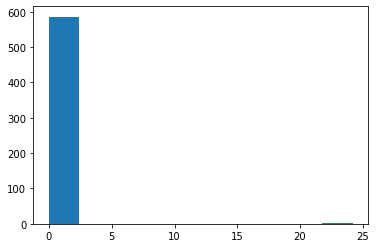

In [15]:
plt.hist(scaled_parameter_array[:, 100])

In [16]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_parameter_array)

PCA()

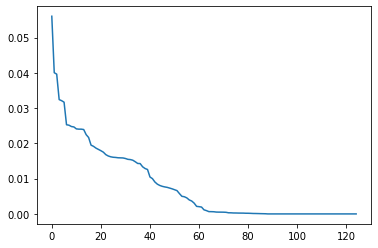

In [17]:
plt.plot(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

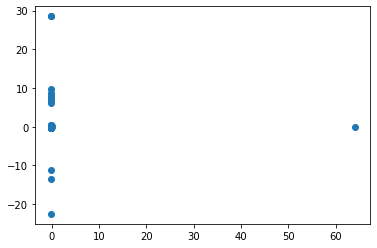

In [18]:
# Plot
scaled_pca = pca.transform(scaled_parameter_array)
plt.plot(scaled_pca[:, 0], scaled_pca[:, 1], 'o')

In [19]:
# Now perform clustering
from sklearn.mixture import GaussianMixture
for nc in range(2, 50, 5):
    gm = GaussianMixture(n_components=nc, random_state=9102, n_init=5).fit(parameter_array)
    print(f"Number of components: {nc}, BIC = {gm.bic(parameter_array)}")

Number of components: 2, BIC = -291465.78238978836
Number of components: 7, BIC = -77201.31885741436
Number of components: 12, BIC = 139473.7875842813
Number of components: 17, BIC = 286848.7078928938
Number of components: 22, BIC = 480219.15027477907
Number of components: 27, BIC = 636656.2865123656
Number of components: 32, BIC = 916339.7207703879
Number of components: 37, BIC = 1079272.256440338
Number of components: 42, BIC = 1390528.3933994952
Number of components: 47, BIC = 1581523.4776501616


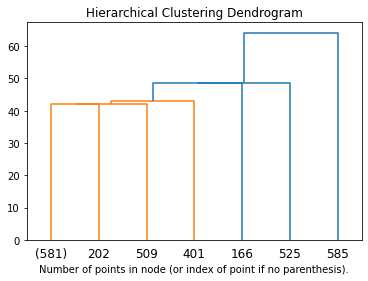

In [22]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

model = model.fit(scaled_parameter_array)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [19]:
latent_dim = 2  # number of latent dimensions
num_inducing = 10  # number of inducing pts
num_data = scaled_parameter_array.shape[0]  # number of data points

In [20]:
from gpflow.utilities import ops
import tensorflow as tf
from gpflow.config import default_float
X_mean_init = ops.pca_reduce(scaled_parameter_array, latent_dim)
X_var_init = tf.ones((num_data, latent_dim), dtype=default_float())

In [21]:
np.random.seed(1)  # for reproducibility
inducing_variable = tf.convert_to_tensor(
    np.random.permutation(X_mean_init.numpy())[:num_inducing], dtype=default_float()
)

In [22]:
lengthscales = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.Matern12(lengthscales=lengthscales)

In [52]:
# gplvm = gpflow.models.BayesianGPLVM(
#     scaled_parameter_array,
#     X_data_mean=X_mean_init,
#     X_data_var=X_var_init,
#     kernel=kernel,
#     inducing_variable=inducing_variable,
# )
# # Instead of passing an inducing_variable directly, we can also set the num_inducing_variables argument to an integer, which will randomly pick from the data.

gplvm = gpflow.models.GPLVM(
    data=scaled_parameter_array,
    latent_dim=2,
    kernel=gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscales))
)

In [53]:
opt = gpflow.optimizers.Scipy()
maxiter = ci_niter(10000)
opt.minimize(
    gplvm.training_loss,
    method="BFGS",
    variables=gplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)

      fun: -53734.88442309209
 hess_inv: array([[ 1.70372828e-03,  3.56213414e-08,  1.70358624e-03, ...,
        -5.97819150e-07,  3.24879133e-07,  2.31086871e-06],
       [ 3.56079899e-08,  1.70373407e-03,  4.06449580e-08, ...,
        -1.73357756e-06,  2.73496155e-07,  5.08710062e-06],
       [ 1.70358624e-03,  4.00252286e-08,  1.70375023e-03, ...,
        -5.52643969e-07, -1.25554529e-07, -1.10888696e-06],
       ...,
       [-6.01513771e-07, -1.75515859e-06, -5.63174999e-07, ...,
         4.24953729e-05,  2.54639990e-05, -7.00192011e-05],
       [ 3.38278981e-07,  2.38452435e-07, -1.77928526e-07, ...,
         2.60136488e-05,  2.85610301e-04,  8.00247282e-06],
       [ 2.31865733e-06,  4.98787056e-06, -1.08738208e-06, ...,
        -6.75674521e-05,  9.04085312e-06,  7.70119254e-04]])
      jac: array([ 5.36552964e+05, -1.72610030e+05, -1.38357222e+04, ...,
       -3.23356434e+01,  2.63110154e+00,  2.50630783e-01])
  message: 'Desired error not necessarily achieved due to precision l

In [54]:
gplvm

<gpflow.models.gplvm.GPLVM object at 0x2c14918b0>
╒═══════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤══════════════════════════════════════╕
│ name                                  │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                                │
╞═══════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪══════════════════════════════════════╡
│ GPLVM.kernel.base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 2.2942249441084757                   │
├───────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────────────────┤
│ GPLVM.kernel.base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)     │ float64 │ [0.01576402 0.07998555]              │
├───────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────────────────┤
│ GPLVM.kernel.period                   │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 0.4674368092844242                   │
├───────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────────────────┤
│ GPLVM.likelihood.variance             │ Parameter │ Softplus + Shift │         │ True        │ ()       │ float64 │ 1.0000377813490493e-06               │
├───────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────────────────┤
│ GPLVM.data[0]                         │ Parameter │ Identity         │         │ True        │ (587, 2) │ float64 │ [[-2.42622361e-01, 1.32394405e-01... │
╘═══════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════════╧═════════╧══════════════════════════════════════╛

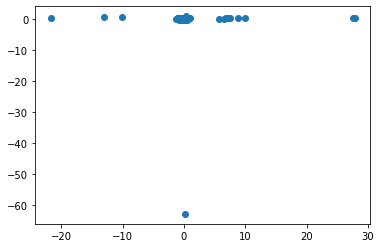

In [55]:
plt.scatter(gplvm.data[0][:, 0], gplvm.data[0][:, 1])

In [35]:
gplvm_X_mean = gplvm.X_data_mean.numpy()
plt.scatter(gplvm_X_mean[:, 0], gplvm_X_mean[:, 1])

AttributeError: 'GPLVM' object has no attribute 'X_data_mean'

In [29]:
# ICA
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=2,
        random_state=0)
X_transformed = transformer.fit_transform(scaled_parameter_array)
X_transformed.shape

(587, 2)

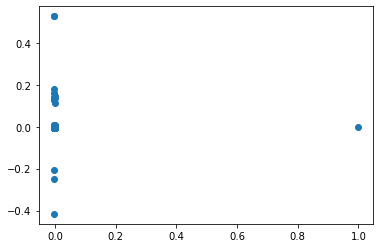

In [30]:
plt.scatter(X_transformed[:, 0], X_transformed[:, 1])

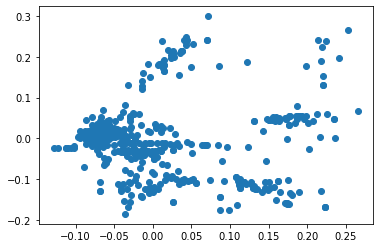

In [32]:
# Kernel PCA
from sklearn.decomposition import KernelPCA
transformer = KernelPCA(n_components=10, kernel='sigmoid')
X_transformed = transformer.fit_transform(scaled_parameter_array)
X_transformed.shape
plt.scatter(X_transformed[:, 0], X_transformed[:, 1])

## HMC Sampling

In [14]:
c_samples, samples, traces = hmc_sampling(
    model = gaussian_dict[cur_metabolite][cur_kernel][1]
)

KeyboardInterrupt: 

In [86]:
foo = gpflow.models.GPMC(
    data = (df[['id', 'hbi', 'days_from_start']].to_numpy().reshape(-1, 3),
            df[[m]].isna().astype(int).to_numpy().reshape(-1, 1)),
    kernel = Categorical(active_dims=[0]),
    likelihood = gpflow.likelihoods.Gaussian())

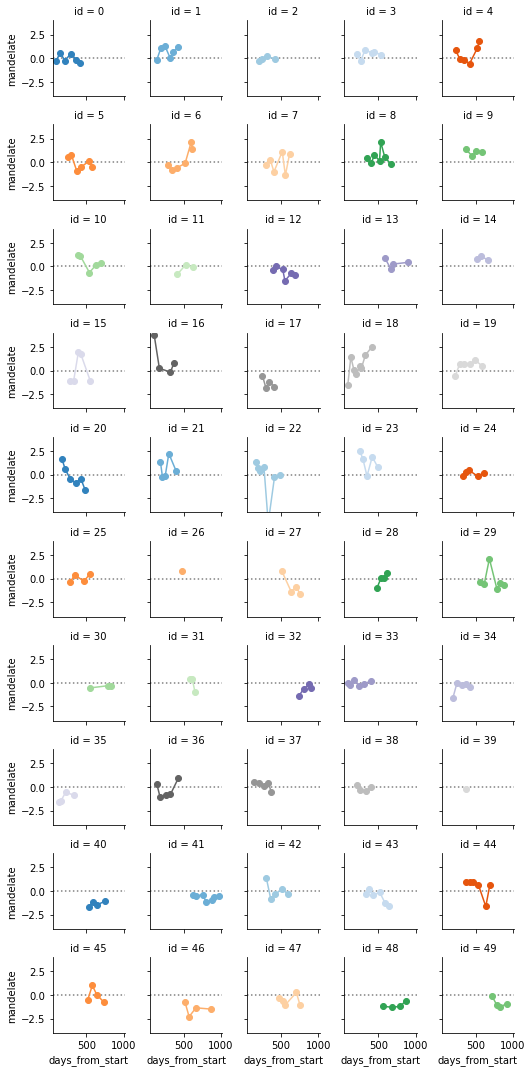

In [78]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df[['id', 'days_from_start', 'mandelate']].sort_values(by=['id', 'days_from_start']), 
                     col="id", hue="id", palette="tab20c",
                     col_wrap=5, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "days_from_start", "mandelate", marker="o")

# Adjust the tick positions and labels
grid.set(ylim=(-4, 4))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

## Reversing question - HBI output 

Flip the X and Y search to find relationships with HBI

<AxesSubplot:>

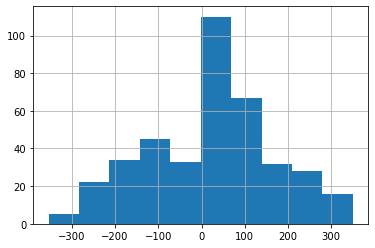

In [6]:
df_original.days_from_max_severity.hist()

<AxesSubplot:>

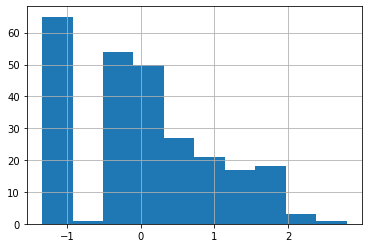

In [13]:
df_cd = df_original.query("diagnosis == 0")
((np.log(df_cd.severity+1) - np.log(df_cd.severity+1).mean())/np.log(df_cd.severity+1).std()).hist()

<AxesSubplot:>

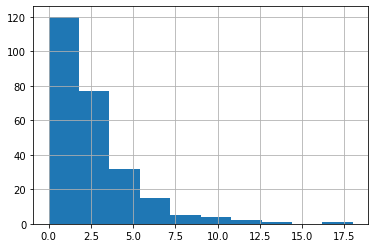

In [14]:
df_cd.severity.hist()

In [3]:
df_original.drop(['hbi', 'days_from_max_hbi'], axis=1).fillna(0)

id  12.13-diHOME  9.10-diHOME  caproate  heptanoate  hydrocinnamate  \
0     0      942546.0    1418451.0    2194.0         0.0         38180.0   
1     0      584730.0    1955625.0    2305.0         0.0         69475.0   
2     0      555437.0     739486.0     670.0         0.0          9780.0   
3     0      937676.0    1002635.0    1295.0         0.0         17147.0   
4     0     1286163.0    1453551.0    2920.0         0.0         23123.0   
..   ..           ...          ...       ...         ...             ...   
265  48     2930386.0    2661474.0     178.0         0.0         22508.0   
266  49     1396087.0    1244904.0   30840.0     28640.0         61584.0   
267  49     1271586.0    2141391.0   66048.0     50758.0        101785.0   
268  49     1225142.0    1401222.0   17584.0     19881.0         47605.0   
269  49     1742559.0    2084184.0   40382.0     49311.0         44659.0   

     mandelate  2-hydroxyoctanoate  3-hydroxyoctanoate   caprate  ...  \
0       5893.0                 0.0              4174.0  211440.0  ...   
1      10406.0                 0.0              6601.0  129697.0  ...   
2       6117.0                 0.0              5480.0   63415.0  ...   
3       9764.0                 0.0              6779.0   31365.0  ...   
4       6514.0                 0.0              3975.0  343826.0  ...   
..         ...                 ...                 ...       ...  ...   
265     4892.0                 0.0              2441.0   42024.0  ...   
266     6709.0           1482663.0              4433.0   18237.0  ...   
267     3688.0           1097574.0              4428.0    6730.0  ...   
268     3216.0            685250.0              4044.0   14284.0  ...   
269     3978.0            884012.0              2760.0   12413.0  ...   

     C16:1 LPC plasmalogen  C18:1 LPC plasmalogen  C18:0 LPE-A  C18:0 LPE-B  \
0                 287048.0               453688.0    9997928.0    3579319.0   
1                 113495.0               130737.0   16335239.0   13177075.0   
2                 143163.0                 3760.0    4371214.0    2130907.0   
3                  96874.0                18460.0    3306645.0    2323331.0   
4                 224205.0                    0.0    8323839.0    2529248.0   
..                     ...                    ...          ...          ...   
265               125558.0                23226.0    9858268.0          0.0   
266               788898.0              1729149.0   13016948.0    5784254.0   
267              5124004.0             16952058.0   68633482.0   15729655.0   
268               540608.0               587943.0   13183706.0    4966755.0   
269               910008.0              1149106.0   12490726.0          0.0   

      C22:6 LPE  sphingosine-isomer1  sphingosine-isomer2  \
0     2066660.0          274385476.0          136360623.0   
1     4447184.0          121055143.0           65245288.0   
2    10511485.0          199161782.0          106462063.0   
3     1555152.0          187973992.0           97169686.0   
4     4901090.0          152639719.0           79560140.0   
..          ...                  ...                  ...   
265  11257588.0          145032134.0           80538278.0   
266  30645661.0           29795152.0           17180991.0   
267   8104673.0           37447160.0           22914873.0   
268   3244635.0           37310887.0           21275433.0   
269  11382428.0            6957821.0            4334584.0   

     sphingosine-isomer3  C14:0 SM  days_from_start  
0           2.119068e+08   36328.0               93  
1           3.015463e+08   51577.0              149  
2           1.181831e+08       0.0              211  
3           7.215191e+07       0.0              293  
4           2.258123e+08    6212.0              364  
..                   ...       ...              ...  
265         6.841049e+08       0.0              867  
266         1.566264e+09    3201.0              720  
267         2.857219e+09  376859.0             

In [15]:
hbi_ard = gpflow.models.GPR(
    data=(df_original.drop(['hbi', 'days_from_max_hbi'], axis=1).iloc[:, :10].fillna(0).astype(float).to_numpy(),
          df_original.days_from_max_hbi.astype(float).to_numpy().reshape(-1, 1)),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=10*[1.])
)
opt_results = gpflow.optimizers.Scipy().minimize(
    hbi_ard.training_loss,
    hbi_ard.trainable_variables
)
hbi_ard

<gpflow.models.gpr.GPR object at 0x7fe87f328880>
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 10385.777714315547 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (10,)   │ float64 │ [1., 1., 1....     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 10385.784876295256 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════╛

<AxesSubplot:>

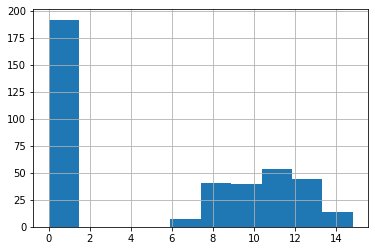

In [20]:
np.log(df_original['C14:0 SM'].fillna(0) + 1).hist()

In [28]:
# Fill in zeros and transform input metabolite data
df_transform = df_original.copy()
df_transform.iloc[:, 5:-2] = np.log(df.iloc[:, 5:-2].fillna(0) + 1)
df_transform['days_from_start'] = df['days_from_start']

In [29]:
df_transform.head()

id  diagnosis  race  sex  severity  12.13-diHOME  9.10-diHOME  caproate  \
0   0          0     0    0       4.0     13.756341    14.165077  7.693937   
1   0          0     0    0       3.0     13.278907    14.486221  7.743270   
2   0          0     0    0       3.0     13.227512    13.513712  6.508769   
3   0          0     0    0       4.0     13.751161    13.818143  7.167038   
4   0          0     0    0       7.0     14.067175    14.189521  7.979681   

   heptanoate  hydrocinnamate  ...  C18:1 LPC plasmalogen  C18:0 LPE-A  \
0         0.0       10.550093  ...              13.025167    16.117889   
1         0.0       11.148737  ...              11.780951    16.608835   
2         0.0        9.188197  ...               8.232440    15.290552   
3         0.0        9.749637  ...               9.823416    15.011445   
4         0.0       10.048626  ...               0.000000    15.934634   

   C18:0 LPE-B  C22:6 LPE  sphingosine-isomer1  sphingosine-isomer2  \
0    15.090683  14.541445            19.430045            18.730814   
1    16.393989  15.307782            18.611757            17.993664   
2    14.572059  16.167979            19.109628            18.483299   
3    14.658513  14.257084            19.051814            18.391969   
4    14.743433  15.404968            18.843591            18.192024   

   sphingosine-isomer3   C14:0 SM  days_from_start  days_from_max_severity  
0            19.171657  10.500372        -1.989274                    -271  
1            19.524434  10.850851        -1.712809                    -215  
2            18.587746   0.000000        -1.406722                    -153  
3            18.094284   0.000000        -1.001898                     -71  
4            19.235215   8.734399        -0.651379                       0  

[5 rows x 551 columns]

In [3]:
%%time
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               #gpflow.kernels.ArcCosine(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

severity_model = full_kernel_search(
    X=df_transform.drop(['diagnosis', 'severity', 'days_from_max_severity'], axis=1),
    Y=df_transform.severity,
    kern_list=kernel_list,
    cat_vars=[0, 1, 2, 3],
    max_depth=3,
    early_stopping=True,
    prune=True,
    keep_all=False,
    # lik = 'gaussian',
    lik='poisson',
    verbose=True,
    random_seed=9102
)

Working on depth 1 now
-----------

Working on depth 2 now


KeyboardInterrupt: 

In [10]:
hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1]

<gpflow.models.gpr.GPR object at 0x7fb6587715e0>
╒════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                                   │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c                    │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [2.52479895]           │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].variance         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 25.405110621075966     │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].bias_variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 25.18753071214904      │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].weight_variances │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 4.4648888609643005e-12 │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].variance         │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1.0                    │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].bias_variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 8.629136956169125      │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].weight_variances │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.00019943660766734504 │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.likelihood.variance                │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.5772653636730716     │
╘════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════════╛

Metabolite 123
Metabolite 498


<AxesSubplot:>

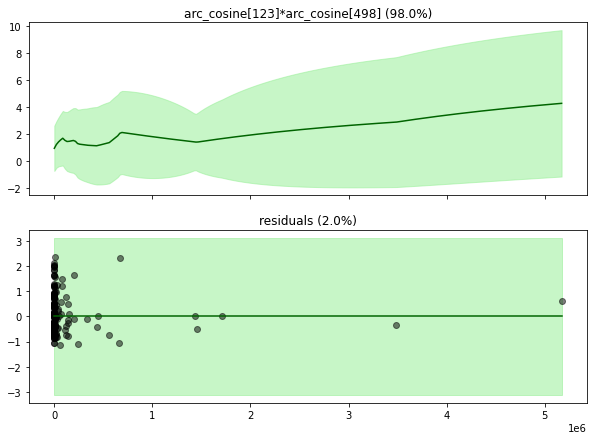

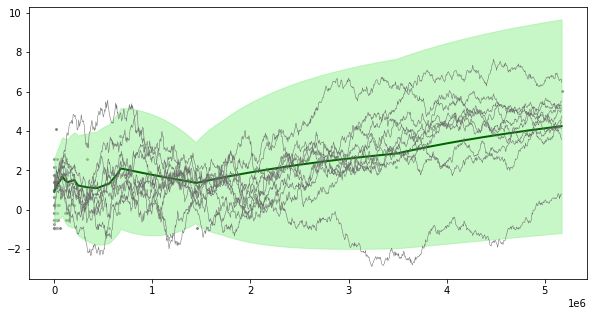

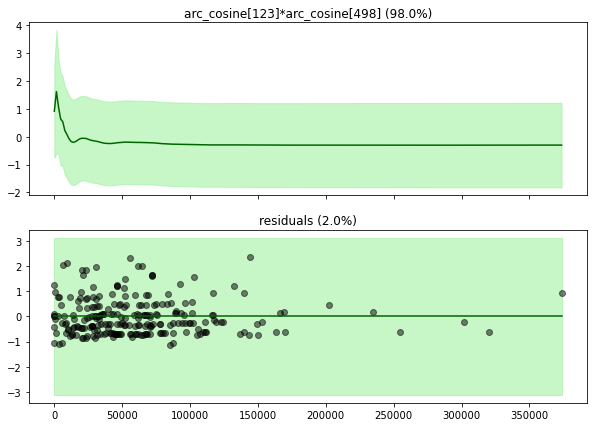

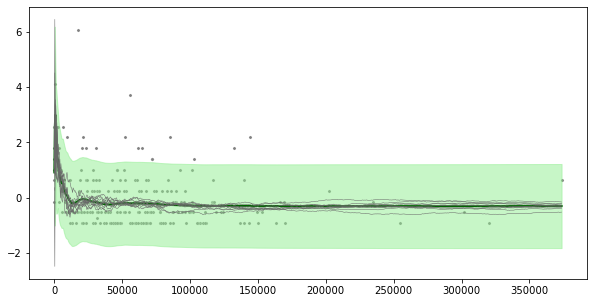

In [14]:
# Print resulting decomposition
print('Metabolite 123')
pred_kernel_parts(hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1],
                  'arc_cosine[123]*arc_cosine[498]',
                  x_idx=123)
gp_predict_fun(
    hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1], 
    x_idx=123, 
    unit_idx=0,
    unit_label=10,
    num_funs=10
)

print('Metabolite 498')
pred_kernel_parts(hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1],
                  'arc_cosine[123]*arc_cosine[498]',
                  x_idx=498)

gp_predict_fun(
    hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1], 
    x_idx=498, 
    unit_idx=0,
    unit_label=10,
    num_funs=10
)


In [18]:
# Which metabolites are these?
df.drop(['id', 'hbi'], axis=1).columns[[123, 498]]

Index(['C38:3 PC', 'cortisol'], dtype='object')

In [4]:
int_model = gpflow.models.GPR(
    data=(df[['C38:3 PC', 'cortisol']].fillna(0).to_numpy().reshape(-1, 2),
          df.hbi.to_numpy().reshape(-1, 1)),
    kernel=gpflow.kernels.ArcCosine(active_dims=[0])*gpflow.kernels.ArcCosine(active_dims=[1]),
    mean_function=gpflow.mean_functions.Constant())

opt_results = gpflow.optimizers.Scipy().minimize(
                int_model.training_loss,
                int_model.trainable_variables)

In [5]:
int_model

<gpflow.models.gpr.GPR object at 0x7fcb64381370>
╒════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                                   │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c                    │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [8.89900516]           │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].variance         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 12.997128050057611     │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].bias_variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 21.246525691023113     │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].weight_variances │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.768662316411443e-12  │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].variance         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 12.997128050080763     │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].bias_variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 5.864056279920286      │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].weight_variances │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.00013386546254106477 │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.likelihood.variance                │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 3.853896225206588      │
╘════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════════╛

<AxesSubplot:>

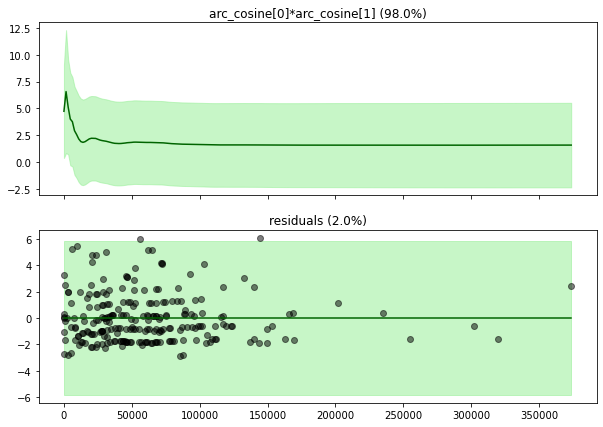

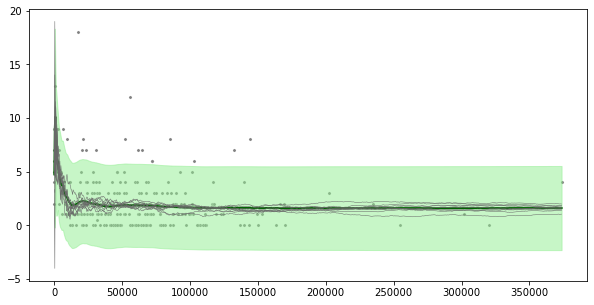

In [6]:
pred_kernel_parts(int_model,
#                   'squared_exponential[0]*squared_exponential[1]',
                  'arc_cosine[0]*arc_cosine[1]',
                  x_idx=1)

gp_predict_fun(
    int_model, 
    x_idx=1, 
    unit_idx=0,
    unit_label=10,
    num_funs=10
)

In [69]:
'*' in 'arc_cosine[0]*arc_cosine[1]'

True

In [63]:
x1 = np.linspace(0, df['C38:3 PC'].max(), num=100).round(0)
x2 = np.linspace(0, df['cortisol'].max(), num=100).round(0)
x_new = np.array(
    np.meshgrid(
        x1, x2
    )
).T.reshape(-1, 2)

mean_y, var_y = int_model.predict_y(
    Xnew = x_new
)

In [101]:
var_y

<tf.Tensor: shape=(10000, 1), dtype=float64, numpy=
array([[4.89433849],
       [5.12543689],
       [4.39932493],
       ...,
       [7.77666255],
       [7.77725733],
       [7.77784009]])>

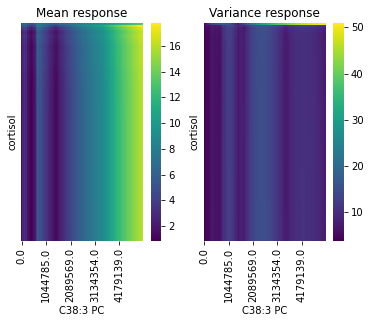

In [109]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

sns.heatmap(pd.DataFrame({'mean':mean_y.numpy().flatten(), 
              'cortisol': x_new[:,1].flatten(), 
              'C38:3 PC': x_new[:,0].flatten()}).pivot('cortisol', 'C38:3 PC', 'mean'),
           xticklabels=20,
           yticklabels=20,
           cmap='viridis',
           ax=ax1)
ax1.set_title('Mean response')
sns.heatmap(pd.DataFrame({'var':var_y.numpy().flatten(), 
              'cortisol': x_new[:,1].flatten(), 
              'C38:3 PC': x_new[:,0].flatten()}).pivot('cortisol', 'C38:3 PC', 'var'),
           xticklabels=20,
           yticklabels=False,
           cmap='viridis',
           ax=ax2)
ax2.set_title('Variance response')

plt.show()

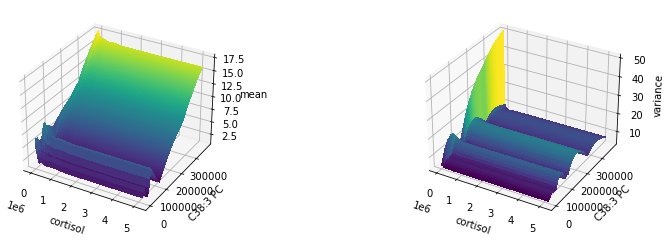

In [126]:
from mpl_toolkits.mplot3d import Axes3D
x1_, x2_ = np.meshgrid(x1, x2)


# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

# Mean response
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
ax.plot_surface(x1_, x2_, mean_y.numpy().reshape(x1_.shape), 
                rstride=1, cstride=1, cmap='viridis',
                linewidth=0, antialiased=False)
ax.set_ylabel('C38:3 PC')
ax.set_xlabel('cortisol')
ax.set_zlabel('mean')

# Variance response
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_surface(x1_, x2_, var_y.numpy().reshape(x1_.shape), 
                rstride=1, cstride=1, cmap='viridis',
                linewidth=0, antialiased=False)
ax.set_ylabel('C38:3 PC')
ax.set_xlabel('cortisol')
ax.set_zlabel('variance')
plt.show()

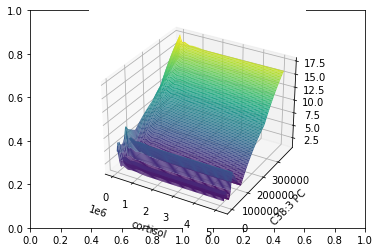

In [111]:
from mpl_toolkits.mplot3d import Axes3D

x1_, x2_ = np.meshgrid(x1, x2)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

ax1 = plt.axes(projection='3d')
ax1.plot_surface(x1_, x2_, 
                mean_y.numpy().reshape(x1_.shape), 
                rstride=1, 
                cstride=1,
                cmap='viridis', 
                edgecolor='none')
ax1.set_ylabel('C38:3 PC')
ax1.set_xlabel('cortisol');

In [70]:
%%time
hbi_model2 = full_kernel_search(
    X=df.drop(['hbi'], axis=1).fillna(0).to_numpy().reshape(-1, 553),
    Y=df[['hbi']].to_numpy().reshape(-1, 1),
    kern_list=[gpflow.kernels.ArcCosine()],
    cat_vars=[0],
    max_depth=3,
    early_stopping=True,
    prune=True,
    keep_all=False,
    lik='gaussian',
    verbose=False
)

Optimization not successful, skipping.
arc_cosine[124]*arc_cosine[499]
CPU times: user 2h 56min 17s, sys: 15min 32s, total: 3h 11min 50s
Wall time: 1h 59min 39s
